# Imports

In [1]:
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from abacusnbody.data.read_abacus import read_asdf
import h5py
import os

import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf

from scipy.spatial import KDTree, cKDTree
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata, UnivariateSpline, interp1d
from scipy.integrate import quad

from collections import Counter
from pycorr import TwoPointCorrelationFunction, TwoPointCounter

import psutil
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import gc
import pickle

import importlib
import functions
importlib.reload(functions)
from functions import *

## Halos

In [ ]:
compaso_dir = '/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_highbase_c000_ph100'

rockstar_dir = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/"
# Liste des fichiers dans le répertoire
rockstar_files = [os.path.join(rockstar_dir, f) for f in os.listdir(rockstar_dir) if f.endswith('.h5')]

print(len(rockstar_files))

160


In [ ]:
first_file = rockstar_files[0]
print(f"Structure du fichier : {first_file}")

# Structure of the first file
with h5py.File(first_file, 'r') as h5file:
    def print_name(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  Dataset : {name} - Shape: {obj.shape}, Type: {obj.dtype}")
    
    h5file.visititems(print_name)  

Structure du fichier : /global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/halos_0.76.h5
  Dataset : halos - Shape: (676323,), Type: [('id', '<i8'), ('parent_id', '<i8'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('corevel', '<f4', (3,)), ('bulkvel', '<f4', (3,)), ('m', '<f4'), ('m_SO', '<f4'), ('r', '<f4'), ('child_r', '<f4'), ('vmax_r', '<f4'), ('mgrav', '<f4'), ('vmax', '<f4'), ('rvmax', '<f4'), ('rs', '<f4'), ('klypin_rs', '<f4'), ('vrms', '<f4'), ('J', '<f4', (3,)), ('energy', '<f4'), ('spin', '<f4'), ('alt_m', '<f4', (4,)), ('alt_m_SO', '<f4', (4,)), ('Xoff', '<f4'), ('Voff', '<f4'), ('b_to_a', '<f4'), ('c_to_a', '<f4'), ('A', '<f4', (3,)), ('b_to_a2', '<f4'), ('c_to_a2', '<f4'), ('A2', '<f4', (3,)), ('bullock_spin', '<f4'), ('kin_to_pot', '<f4'), ('m_pe_b', '<f4'), ('m_pe_d', '<f4'), ('halfmass_radius', '<f4'), ('num_p', '<i8'), ('num_child_particles', '<i8'), ('p_start', '<i8'), ('desc', '<i8'), ('flags', '<i8'), ('n_core', '<i

In [4]:
str_z = 'z0.500'
cols = ['id', 'x_L2com', 'v_L2com', 'N']

path_to_sim = os.path.join(compaso_dir, "halos", str_z)
hcat = CompaSOHaloCatalog(path_to_sim, fields=cols, cleaned=True)
print(hcat.halos)

        id                x_L2com                  v_L2com          N  
----------------- ------------------------ ----------------------- ----
         23000000  -499.30145 .. -470.7527 340.47452 .. -10.998781 9771
         23000001 -499.13162 .. -471.12408  121.88952 .. -95.43646    0
         23000002  -499.05295 .. -470.2627 323.83188 .. -159.35072    0
         23000003  -499.5996 .. -470.80746  594.08124 .. 181.03738   71
         23000004 -499.65613 .. -470.25998  394.56476 .. -626.5086   97
         23000005  -499.4878 .. -471.33203  857.40155 .. 18.161411   57
         24000000 -499.36438 .. -469.81223  57.550785 .. -580.5762  235
         24005000 -499.78503 .. -469.64957  186.10063 .. -536.7594   69
         25000000  -499.63052 .. -469.1773   143.3026 .. -607.3678   40
         34000000 -498.87888 .. -458.02338  151.1486 .. -266.71353   88
              ...                      ...                     ...  ...
82408240655002000     499.7215 .. 294.4206   534.9312 .. 1.22983

## Masses

In [5]:
## CompaSo

Mhalos_CS =  hcat.header['ParticleMassHMsun']*hcat.halos['N']

mask = Mhalos_CS > 0
hcat_filtered = hcat.halos[mask]
Mhalos_filtered_CS = Mhalos_CS[mask]

In [6]:
## Rockstar

data = np.load('/pscratch/sd/g/guittonm/rockstar_halos_filtered.npz')

Mhalos_filtered_RS = data['masses']
ids_filtered_RS = data['ids']
num_particles_filtered_RS = data['num_particles']
positions_RS = data['positions']
velocities_RS = data['velocities']

In [7]:
print(np.shape(Mhalos_filtered_RS))

(107967449,)


## Boxsizes

In [7]:
## Rockstar

file_path_rs = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/rockstar.cfg"
boxsize_rs = get_variable(file_path_rs, name='BOX_SIZE')
print(f"Box size Rockstar: {boxsize_rs}")

## CompaSo
boxsize_cs = hcat.header['BoxSize']
print("Box size CompaSo:", boxsize_cs)

Box size Rockstar: 1000
Box size CompaSo: 1000.0


## Particles

In [ ]:
## CompaSo

# Paths to particle files
field_particle_dirs = [os.path.join(compaso_dir, "halos", str_z, "field_rv_A"),
                       os.path.join(compaso_dir, "halos", str_z, "field_rv_B")]

field_particle_files = [os.path.join(d, f) for d in field_particle_dirs for f in os.listdir(d) if f.endswith(".asdf")]

print(f"Total files to process: {len(field_particle_files)}")

batch_size = 2

file_path = "/pscratch/sd/g/guittonm/all_positions.npy"

# Same positions for both simulations
positions_mm = np.load(file_path, mmap_mode='r')  # mmap_mode for huge data
print(f"Total positions : {positions_mm.shape[0]}")
print("Quelques exemples de positions :")
print(positions_mm[:5])

Total files to process: 32
Total positions : 2538452676
Quelques exemples de positions :
[[-188.28300476 -499.83200073 -496.40100098]
 [-188.26199341 -499.49200439 -495.85198975]
 [-188.37199402 -499.46099854 -495.94299316]
 [-187.76100159 -499.1499939  -495.56900024]
 [-187.60499573 -499.84399414 -495.47900391]]


# Mass study

In [9]:
colors_list = ['green', 'red'] 
colors_ratio=['blue']
labels_name = ['CompaSO', 'Rockstar']
labels_scale = ['Linear', 'Log']
labels_ratio = ['Rockstar / Compaso']


## Bins

In [10]:
# Linear bins
bins = np.histogram_bin_edges(np.concatenate([Mhalos_filtered_RS, Mhalos_filtered_CS]), bins=50)

# Logarithmic bins
min_mass = max(Mhalos_filtered_RS.min(), Mhalos_filtered_CS.min())
max_mass = max(Mhalos_filtered_RS.max(), Mhalos_filtered_CS.max())
bins_log = np.logspace(np.log10(min_mass), np.log10(max_mass), num=50)
bins_log_centers = 0.5 * (bins_log[:-1] + bins_log[1:])

## HMF

In [11]:
hmf_rs_log, bin_centers_rs_log = compute_hmf(Mhalos_filtered_RS, bins_log)
hmf_cs_log, bin_centers_cs_log = compute_hmf(Mhalos_filtered_CS, bins_log)

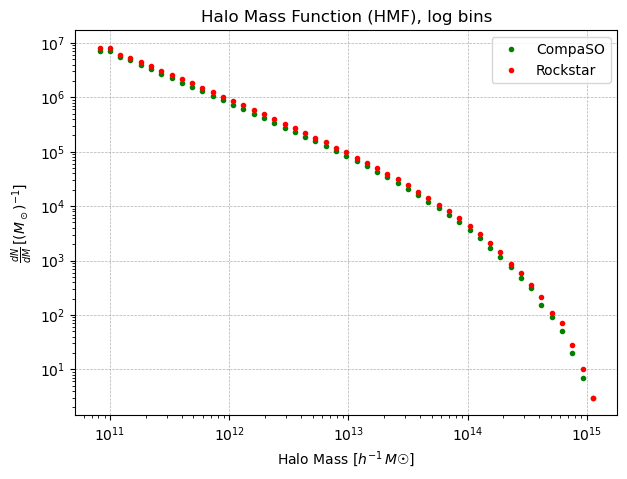

In [12]:
data_hmf = [hmf_cs_log, hmf_rs_log]
bins_hmf = [bin_centers_cs_log, bin_centers_rs_log]

plot_masses_fct(data_hmf, bins_hmf, colors_list, labels_name, linestyles_list=['none','none'], title='Halo Mass Function (HMF), log bins', ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$')

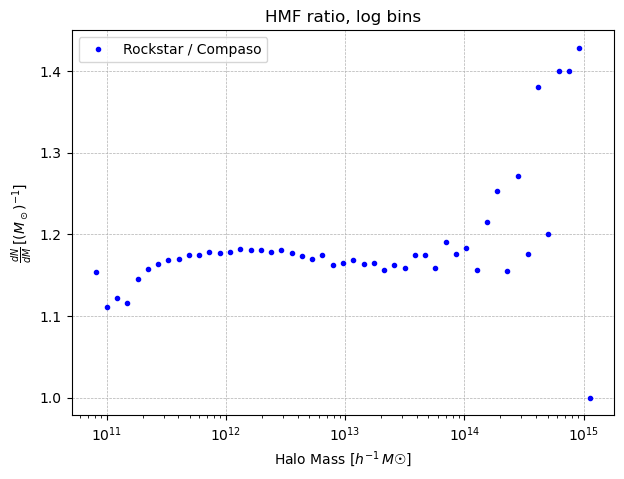

In [13]:
plot_masses_fct([hmf_rs_log / hmf_cs_log], [bin_centers_rs_log], colors_list=colors_ratio, labels_list=labels_ratio, linestyles_list=['none'], scale='semilogx', title='HMF ratio, log bins', ylabel=r'$\frac{dN}{dM} \, [(M_\odot)^{-1}]$')

## Empty bins

In [14]:
# Ratio count, linear
counts_rs, _ = np.histogram(Mhalos_filtered_RS, bins=bins)
counts_cs, _ = np.histogram(Mhalos_filtered_CS, bins=bins)

# Ratio count, log
counts_rs_log, _ = np.histogram(Mhalos_filtered_RS, bins=bins_log)
counts_cs_log, _ = np.histogram(Mhalos_filtered_CS, bins=bins_log)

# Rockstar total masses
mass_sums_rs_log = compute_mass_sums(Mhalos_filtered_RS, bins_log)
mass_sums_rs = compute_mass_sums(Mhalos_filtered_RS, bins)

# CompaSO total masses
mass_sums_cs_log = compute_mass_sums(Mhalos_filtered_CS, bins_log)
mass_sums_cs = compute_mass_sums(Mhalos_filtered_CS, bins)

In [15]:
# Check empty bins in mass, linear
data_bins = [mass_sums_rs, mass_sums_rs_log, mass_sums_cs, mass_sums_cs_log]
labels_bins = ['Rockstar, linear',
               'Rockstar, log',
               'CompaSO, linear',
               'CompaSO, log']
title_bins = 'Bins of null mass'
bins_empty_rs, bins_empty_rs_log, bins_empty_cs, bins_empty_cs_log = check_empty_bins(data_bins, labels_bins, title_bins)

data_bins2 = [counts_rs, counts_rs_log, counts_cs, counts_cs_log]
labels_bins2 = ['Rockstar, linear', 
                'Rockstar, log',
                'CompaSO, linear',
                'CompaSO, log']
title_bins2 = 'Empty bins'
bins_zero_count_rs, bins_zero_count_rs_los, bins_zero_count_cs, bins_zero_count_cs_log = check_empty_bins(data_bins2, labels_bins2, title_bins2)


 Bins of null mass : 

Rockstar, linear : [33 41 43 45 46 48]
Rockstar, log : []
CompaSO, linear : [35 37 39 40 42 43 44 46 48 49]
CompaSO, log : []

 Empty bins : 

Rockstar, linear : [33 41 43 45 46 48]
Rockstar, log : []
CompaSO, linear : [35 37 39 40 42 43 44 46 48 49]
CompaSO, log : []


# Correlation function

## 10% sample take

In [16]:
## CompaSo

sampled_indices_cs = sample_take(id=hcat_filtered['id'], mass=Mhalos_filtered_CS, percent=0.3)
sampled_masses_cs = Mhalos_filtered_CS[sampled_indices_cs]
sampled_halos_cs = hcat_filtered[sampled_indices_cs]

print(f"CompaSO : Sample of {len(sampled_halos_cs):,} halos. \n")

## Rockstar 

sampled_indices_rs = sample_take(id=ids_filtered_RS, mass=Mhalos_filtered_RS, percent=0.3)
sampled_masses_rs = Mhalos_filtered_RS[sampled_indices_rs] 
sampled_ids_rs = ids_filtered_RS[sampled_indices_rs]
sampled_positions_rs = positions_RS[sampled_indices_rs] 
sampled_velocities_rs = velocities_RS[sampled_indices_rs]

print(f"Rockstar : Sample of {len(sampled_indices_rs):,} halos. \n")

CompaSO : Sample of 14,505,043 halos. 

Rockstar : Sample of 32,390,403 halos. 



In [17]:
# Ratio count, log
sampled_counts_rs_log, _ = np.histogram(sampled_masses_rs, bins=bins_log)
sampled_counts_cs_log, _ = np.histogram(sampled_masses_cs, bins=bins_log)

Attention, il y a des bins vides qui ne s'affichent pas au format log


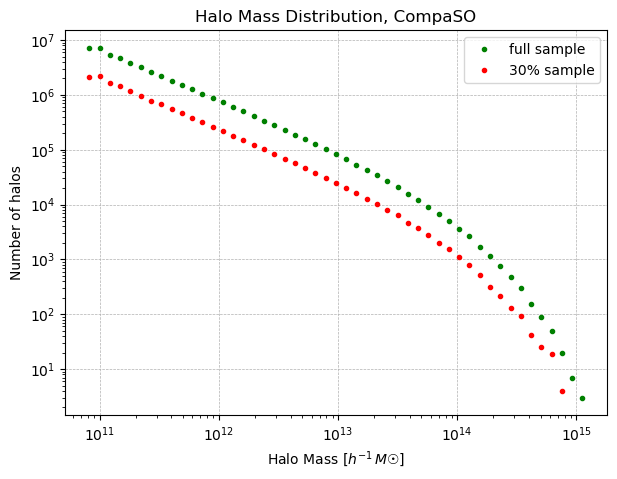

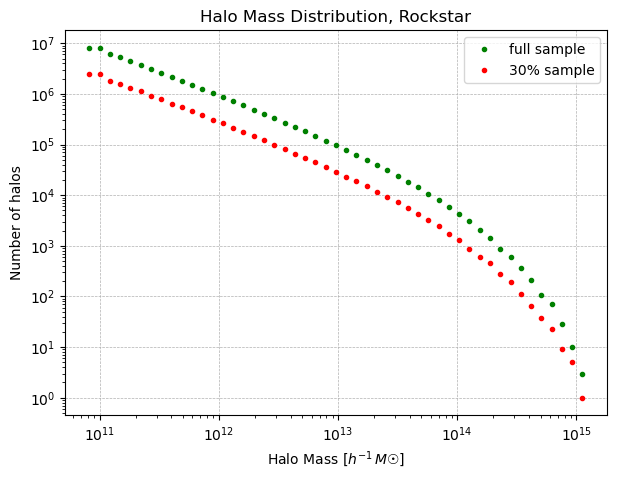

In [18]:
labels = ['full sample', '30% sample']

print("Attention, il y a des bins vides qui ne s'affichent pas au format log")

mass_samples_cs = [Mhalos_filtered_CS, sampled_masses_cs]
counts_samples_cs = [counts_cs_log, sampled_counts_cs_log]

plot_masses_fct(
    data_list=counts_samples_cs, 
    bins_list=[bins_log_centers, bins_log_centers], 
    colors_list=colors_list, 
    labels_list=labels, 
    linestyles_list=['None', 'None'],
    ylabel=r'Number of halos', 
    title='Halo Mass Distribution, CompaSO', 
    scale='loglog', margin_factor =1
)

mass_samples_rs = [Mhalos_filtered_RS, sampled_masses_rs]
counts_samples_rs = [counts_rs_log, sampled_counts_rs_log]

plot_masses_fct(
    data_list=counts_samples_rs, 
    bins_list=[bins_log_centers, bins_log_centers], 
    colors_list=colors_list, 
    labels_list=labels, 
    linestyles_list=['None', 'None'],
    ylabel=r'Number of halos', 
    title='Halo Mass Distribution, Rockstar', 
    scale='loglog', margin_factor =1
)

## Halos positions

In [19]:
## CompaSo
  
positions_cs = np.array(sampled_halos_cs['x_L2com'])
positions_cs = positions_cs.astype(np.float64)

print("Shape of positions:", positions_cs.shape) 
x_cs, y_cs, z_cs = positions_cs[:, 0], positions_cs[:, 1], positions_cs[:, 2]

x_cs = x_cs + boxsize_cs / 2
y_cs = y_cs + boxsize_cs / 2
z_cs = z_cs + boxsize_cs / 2

epsilon = 1e-5
z_cs[z_cs == 0] += epsilon

## Rockstar

# positions_rs = positions_rs.astype(np.float64)
print("Shape of positions:", sampled_positions_rs.shape)
x_rs, y_rs, z_rs = sampled_positions_rs[:, 0], sampled_positions_rs[:, 1], sampled_positions_rs[:, 2]

Shape of positions: (14505043, 3)
Shape of positions: (32390403, 3)


## SMU

### Bins

In [20]:
bins_s = np.linspace(0, 100, 51)  # Distance intervals in Mpc/h
bins_mu = np.linspace(-1, 1, 201)    # Angle cosine intervals

bins_log_s = np.logspace(np.log10(0.13), np.log10(100), 30)

In [21]:
ells = (0, 2, 4)
wedges = (-1., -2./3, -1./3, 0., 1./3, 2./3, 1.)

### 2PCF linear

In [22]:
# ## CompaSO

# results_smu_cs = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Distance markers for bins
#     data_positions1=(x_cs, y_cs, z_cs),  # Halo positions
#     boxsize=boxsize_cs,  
#     los='z',
#     nthreads=26
# )

# # Results
# xi_cs = results_smu_cs.corr  # Values of 2PCF
# rp_cs = results_smu_cs.sep  # Corresponding distances

# print('Shape of s :', rp_cs.shape)  # Should be dimension (n,)
# print(f'Shape of xi(s) : {xi_cs.shape}')

In [23]:
# np.savez('/pscratch/sd/g/guittonm/smu_cs.npz', 
#          results_smu_cs=results_smu_cs,
#          rp_cs=rp_cs, 
#          xi_cs=xi_cs)

data_smu_cs = np.load('/pscratch/sd/g/guittonm/smu_cs.npz', allow_pickle=True)

results_smu_cs = data_smu_cs['results_smu_cs'].item()
rp_cs = data_smu_cs['rp_cs']
xi_cs = data_smu_cs['xi_cs']

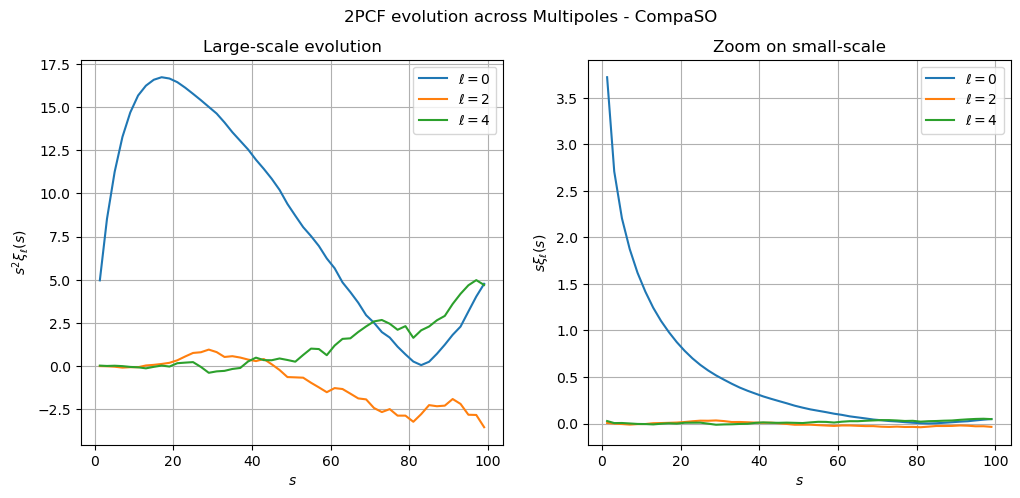

In [24]:
print_multipoles(results_smu_cs, ells, title = 'CompaSO')

In [25]:
# ## Rockstar

# results_smu_rs = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Distance markers for bins
#     data_positions1=(x_rs, y_rs, z_rs),  # Halo positions
#     boxsize=boxsize_rs,  
#     los='z',
#     nthreads=26
# )

# # Results
# xi_rs = results_smu_rs.corr  # Values of 2PCF
# rp_rs = results_smu_rs.sep  # Corresponding distances

# print('Shape of s :', rp_rs.shape)  # Should be dimension (n,)
# print(f'Shape of xi(s) : {xi_rs.shape}')

In [26]:
# np.savez('/pscratch/sd/g/guittonm/smu_rs.npz', 
#          results_smu_rs=results_smu_rs,
#          rp_rs=rp_rs, 
#          xi_rs=xi_rs)

data_smu_rs = np.load('/pscratch/sd/g/guittonm/smu_rs.npz', allow_pickle=True)

results_smu_rs = data_smu_rs['results_smu_rs'].item()
rp_rs = data_smu_rs['rp_rs']
xi_rs = data_smu_rs['xi_rs']

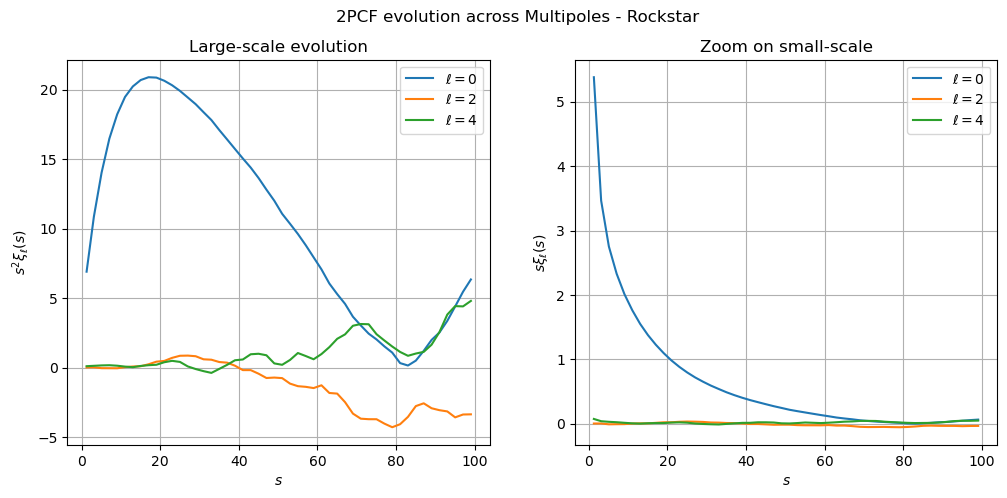

In [27]:
print_multipoles(results_smu_rs, ells, title = 'Rockstar')

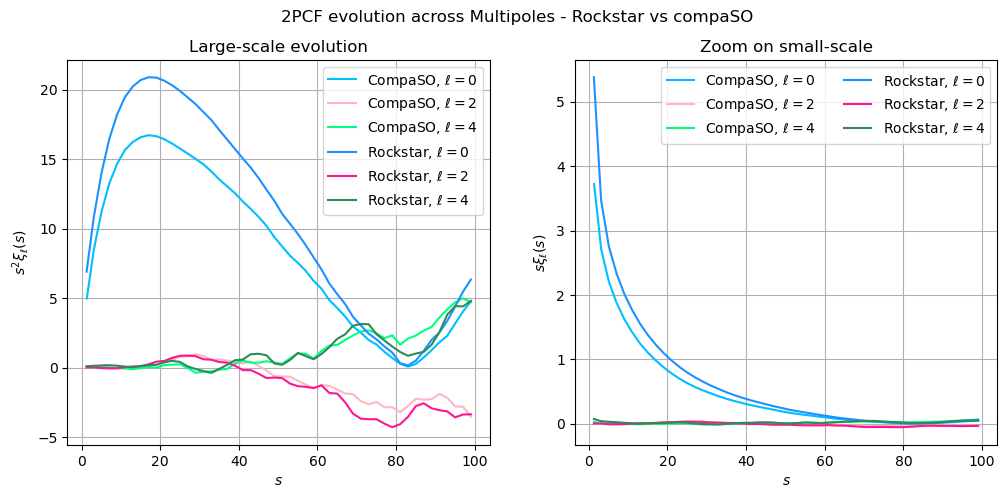

In [28]:
results_smu_list = [results_smu_cs, results_smu_rs]
colors_smu = ['deepskyblue', 'lightpink', 'springgreen', 'dodgerblue', 'deeppink', 'seagreen']

print_many_multipoles(results_list=results_smu_list, labels=['CompaSO', 'Rockstar'], colors_list=colors_smu, ells=ells, title='Rockstar vs compaSO')

### 2PCF log

In [29]:
positions_cs = np.vstack((x_cs, y_cs, z_cs)).T  # Transformer en tableau (N, 3)
tree_cs = cKDTree(positions_cs)

positions_rs = np.vstack((x_rs, y_rs, z_rs)).T  # Transformer en tableau (N, 3)
tree_rs = cKDTree(positions_rs)

# Trouver la distance minimale entre chaque halo et son plus proche voisin
distances, _ = tree_cs.query(positions_cs, k=2)  # `k=2` car le 1er voisin est lui-même
min_distance_cs = np.min(distances[:, 1])  # On prend la distance au 2ème point

distances_rs, _ = tree_cs.query(positions_rs, k=2)  # `k=2` car le 1er voisin est lui-même
min_distance_rs = np.min(distances_rs[:, 1])  # On prend la distance au 2ème point

print(f"Distance minimale entre halos dans CompaSO: {min_distance_cs:.5f} Mpc/h")
print(f"Distance minimale entre halos dans Rockstar: {min_distance_rs:.5f} Mpc/h")

Distance minimale entre halos dans CompaSO: 0.10324 Mpc/h
Distance minimale entre halos dans Rockstar: 0.11589 Mpc/h


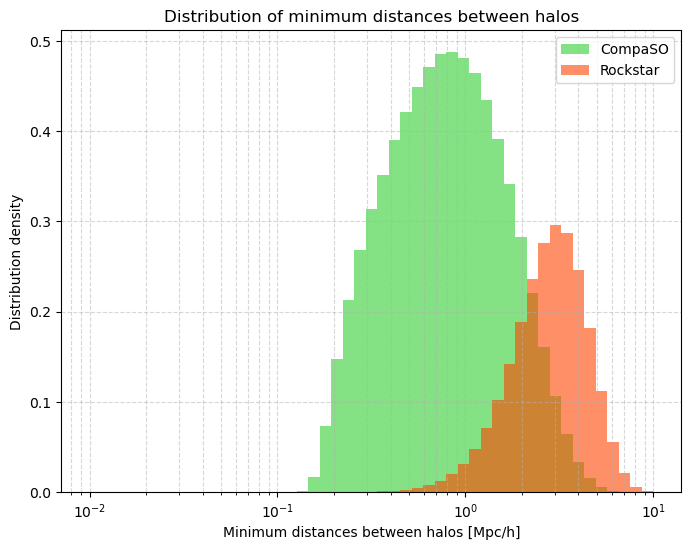

In [30]:
plt.figure(figsize=(8,6))
plt.hist(distances[:, 1], bins=np.logspace(np.log10(0.01), np.log10(10), 50), alpha=0.6, label="CompaSO", density=True, color='limegreen')
plt.hist(distances_rs[:, 1], bins=np.logspace(np.log10(0.01), np.log10(10), 50), alpha=0.6, label="Rockstar", density=True, color='orangered')

plt.xscale("log")
plt.xlabel("Minimum distances between halos [Mpc/h]")
plt.ylabel("Distribution density")
plt.title("Distribution of minimum distances between halos")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

In [31]:
# ## CompaSO

# results_smu_cs_log = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_log_s, bins_mu),  # Distance markers for bins
#     data_positions1=(x_cs, y_cs, z_cs),  # Halo positions
#     boxsize=boxsize_cs,  
#     los='z',
#     nthreads=26
# )

# # Results
# xi_cs_log = results_smu_cs_log.corr  # Values of 2PCF
# rp_cs_log = results_smu_cs_log.sep  # Corresponding distances

In [32]:
# np.savez('/pscratch/sd/g/guittonm/smu_log_cs.npz', 
#          results_smu_cs_log=results_smu_cs_log,
#          rp_cs_log=rp_cs_log, 
#          xi_cs_log=xi_cs_log)

data_smu_cs_log = np.load('/pscratch/sd/g/guittonm/smu_log_cs.npz', allow_pickle=True)

results_smu_cs_log = data_smu_cs_log['results_smu_cs_log'].item()
rp_cs_log = data_smu_cs_log['rp_cs_log']
xi_cs_log = data_smu_cs_log['xi_cs_log']

In [33]:
nan_mask = np.isnan(results_smu_cs_log.sep)

print(f"Nombre total de NaN dans `sep`: {np.sum(nan_mask)}")

if np.sum(nan_mask) > 0:
    print("Indices où `sep` contient des NaN (log_s, mu):")
    nan_indices = np.argwhere(nan_mask)
    print(nan_indices[:20])  # Afficher les 20 premiers indices NaN pour voir la tendance

    print("Corresponding log_s values for NaN:")
    print(bins_log_s[nan_indices[:, 0]])

    print("Corresponding mu values for NaN:")
    print(bins_mu[nan_indices[:, 1]])

Nombre total de NaN dans `sep`: 0


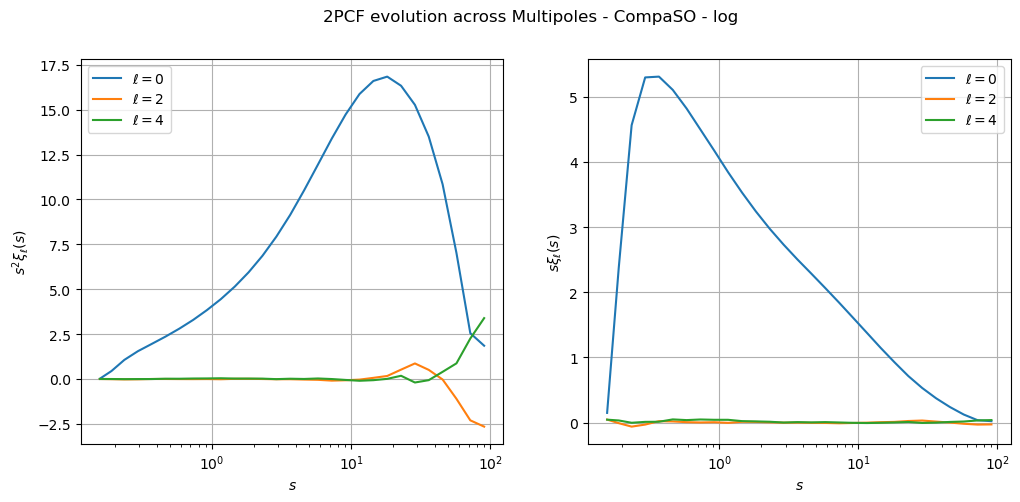

In [34]:
print_multipoles_log(results_smu_cs_log, ells, title = 'CompaSO - log')

In [35]:
# ## Rockstar

# results_smu_rs_log = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_log_s, bins_mu),  # Distance markers for bins
#     data_positions1=(x_rs, y_rs, z_rs),  # Halo positions
#     boxsize=boxsize_rs,  
#     los='z',
#     nthreads=26
# ) 

# # Results 
# xi_rs_log = results_smu_rs_log.corr  # Values of 2PCF
# rp_rs_log = results_smu_rs_log.sep  # Corresponding distances

In [36]:
# np.savez('/pscratch/sd/g/guittonm/smu_log_rs.npz', 
#          results_smu_rs_log=results_smu_rs_log,
#          rp_rs_log=rp_rs_log, 
#          xi_rs_log=xi_rs_log)

data_smu_rs_log = np.load('/pscratch/sd/g/guittonm/smu_log_rs.npz', allow_pickle=True)

results_smu_rs_log = data_smu_rs_log['results_smu_rs_log'].item()
rp_rs_log = data_smu_rs_log['rp_rs_log']
xi_rs_log = data_smu_rs_log['xi_rs_log']

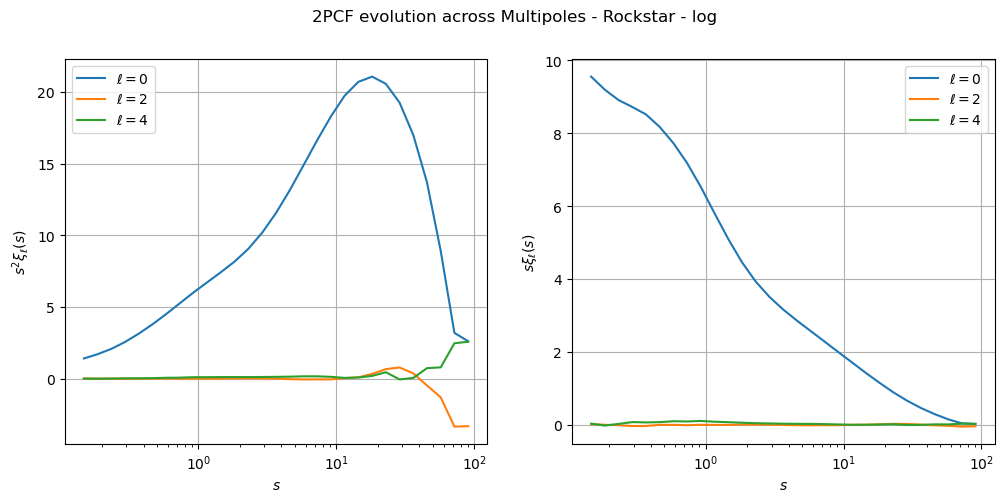

In [37]:
print_multipoles_log(results_smu_rs_log, ells, title = 'Rockstar - log')

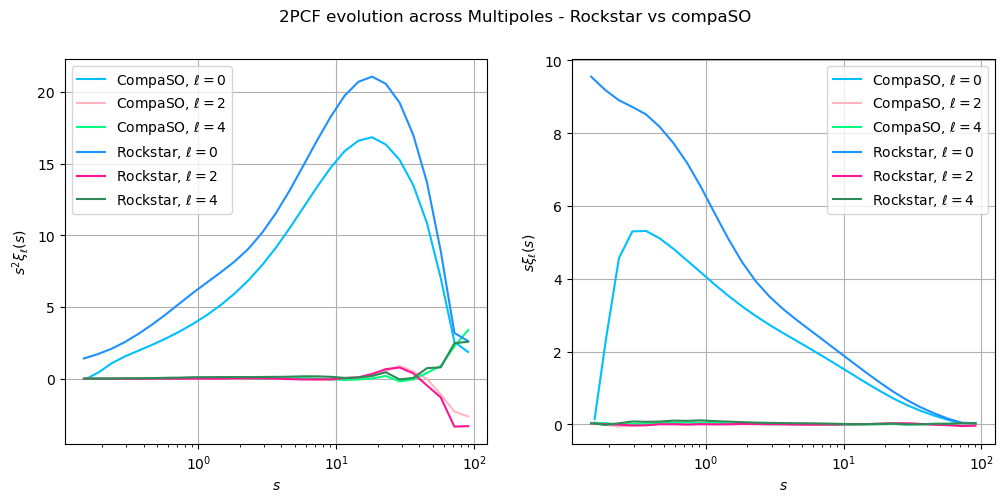

In [38]:
results_smu_log_list = [results_smu_cs_log, results_smu_rs_log]
colors_smu = ['deepskyblue', 'lightpink', 'springgreen', 'dodgerblue', 'deeppink', 'seagreen']

print_many_multipoles_log(results_list=results_smu_log_list, labels=['CompaSO', 'Rockstar'], colors_list=colors_smu, ells=ells, title='Rockstar vs compaSO')

Shape of pairs_s_cs: (29, 200)
Shape of pairs_s_rs: (29, 200)


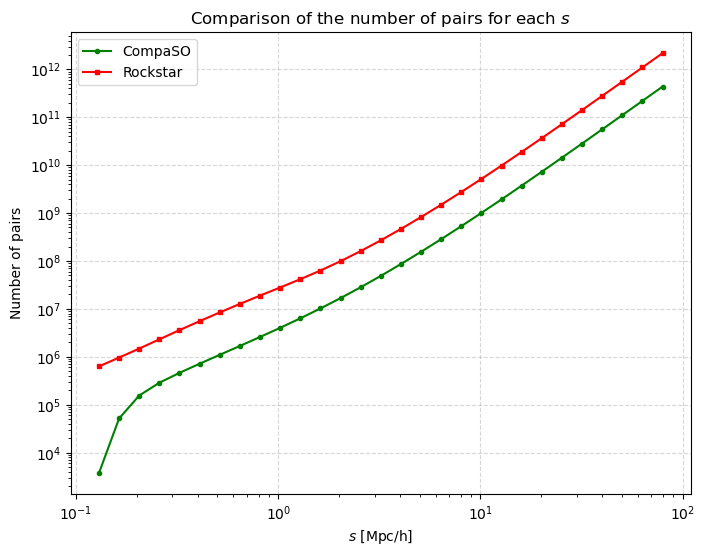

In [39]:
pairs_s_cs = results_smu_cs_log.D1D2.wcounts
pairs_s_rs = results_smu_rs_log.D1D2.wcounts    # Somme sur mu

# Vérification de la forme des données
print("Shape of pairs_s_cs:", pairs_s_cs.shape)
print("Shape of pairs_s_rs:", pairs_s_rs.shape)

# Somme sur mu pour obtenir le nombre de paires par bin de s
pairs_s_cs_summed = np.sum(pairs_s_cs, axis=-1)  
pairs_s_rs_summed = np.sum(pairs_s_rs, axis=-1)

# Tracé du nombre de paires en fonction de s
plt.figure(figsize=(8,6))
plt.loglog(bins_log_s[:-1], pairs_s_cs_summed, label="CompaSO", marker="o", markersize=3, linestyle="-", color='green')
plt.loglog(bins_log_s[:-1], pairs_s_rs_summed, label="Rockstar", marker="s", markersize=3, linestyle="-", color = 'red')

plt.xlabel(r"$s$ [Mpc/h]")
plt.ylabel("Number of pairs")
plt.title("Comparison of the number of pairs for each $s$")
plt.legend()
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.show()

## RPPI

### Bins

In [40]:
# bins_rp = np.linspace(0, 100, 101)  # (0,40,41)
bins_pi = np.linspace(-100, 100, 81)   # (-40,40,81)
bins_rp = np.logspace(np.log10(0.01), np.log10(100), 41) #np.log10(0.01)

### No RSD

In [41]:
# ## CompaSo

# results_rppi_cs = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_cs, y_cs, z_cs),  # Positions des halos
#     nthreads=25,
#     boxsize=boxsize_cs,
#     los='z'
# )

# pi_cs = results_rppi_cs.sepavg(axis=1)
# xi_rppi_cs = results_rppi_cs.corr

In [42]:
# np.savez('/pscratch/sd/g/guittonm/rppi_cs.npz', 
#          results_rppi_cs=results_rppi_cs,
#          pi_cs=pi_cs, 
#          xi_rppi_cs=xi_rppi_cs)

data_rppi_cs = np.load('/pscratch/sd/g/guittonm/rppi_cs.npz', allow_pickle=True)

results_rppi_cs = data_rppi_cs['results_rppi_cs'].item()
pi_cs = data_rppi_cs['pi_cs']
xi_rppi_cs = data_rppi_cs['xi_rppi_cs']

(40, 80)


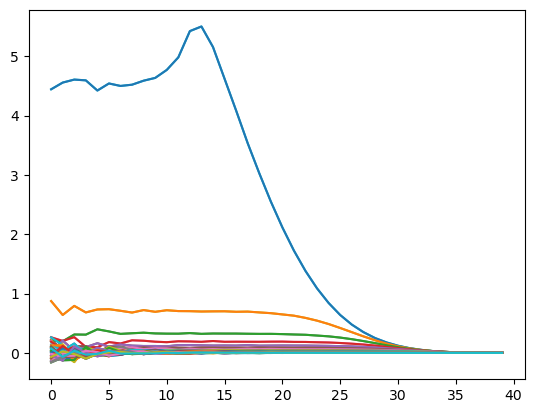

In [43]:
plt.plot(xi_rppi_cs)
print(xi_rppi_cs.shape)

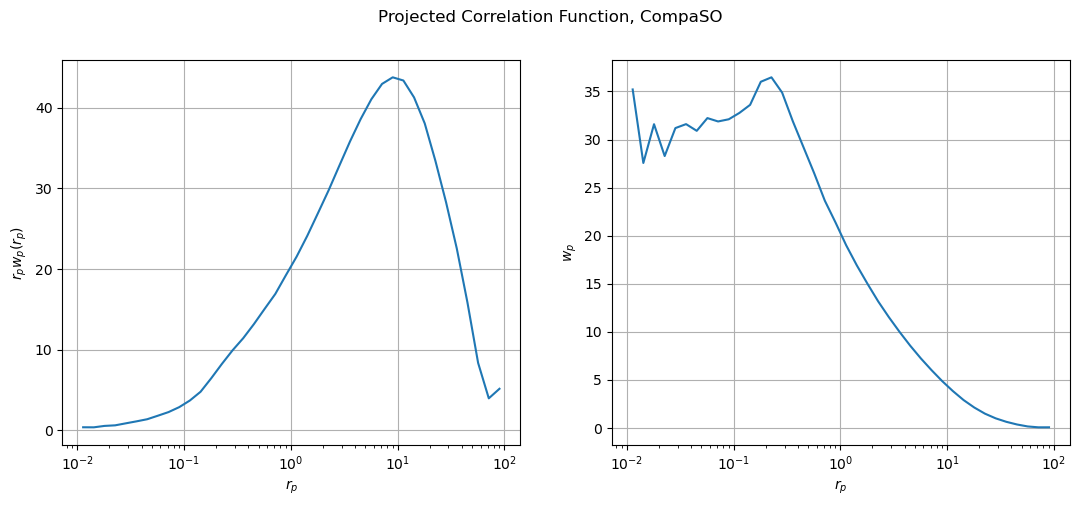

In [44]:
sep_cs = projected_pcf(results_rppi_cs, title='CompaSO')

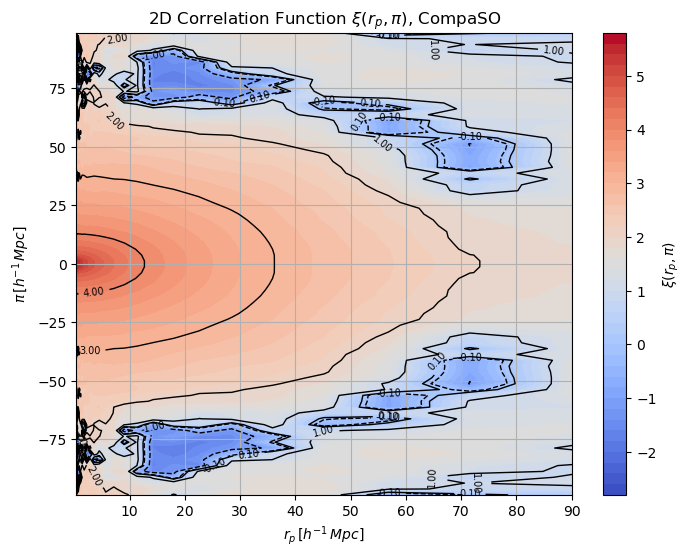

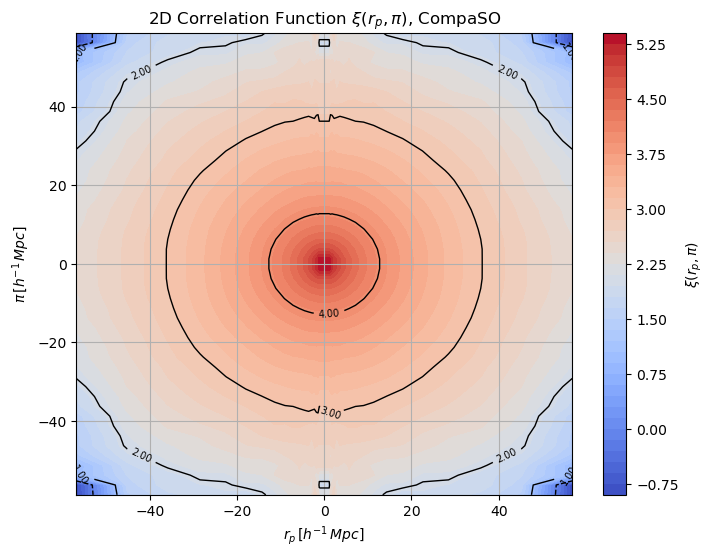

In [45]:
print_xi(results_rppi_cs, pi_lim=100, r_lim=0.3, title='CompaSO')

# print_xi_round_test_nolog(results_rppi_cs, pi_lim=50, r_lim=50, r_lim_min=0.5, title='CompaSO')

print_xi_round(results_rppi_cs, pi_lim=60, r_lim=60, r_lim_min=1, title='CompaSO')


In [46]:
# ## Rockstar

# results_rppi_rs = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_rs, y_rs, z_rs),  # Positions des halos
#     nthreads=25,
#     boxsize=boxsize_cs,
#     los='z'
# )

# pi_rs = results_rppi_rs.sepavg(axis=1)
# xi_rppi_rs = results_rppi_rs.corr

In [47]:
# np.savez('/pscratch/sd/g/guittonm/rppi_rs.npz', 
#          results_rppi_rs=results_rppi_rs,
#          pi_rs=pi_rs, 
#          xi_rppi_rs=xi_rppi_rs)

data_rppi_rs = np.load('/pscratch/sd/g/guittonm/rppi_rs.npz', allow_pickle=True)

results_rppi_rs = data_rppi_rs['results_rppi_rs'].item()
pi_rs = data_rppi_rs['pi_rs']
xi_rppi_rs = data_rppi_rs['xi_rppi_rs']

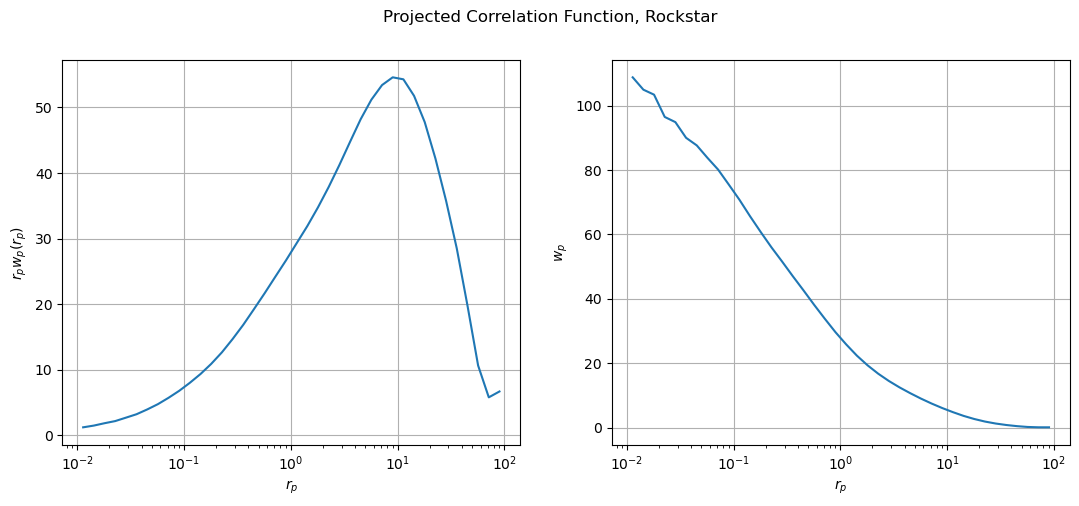

In [48]:
sep_rs = projected_pcf(results_rppi_rs, title='Rockstar')

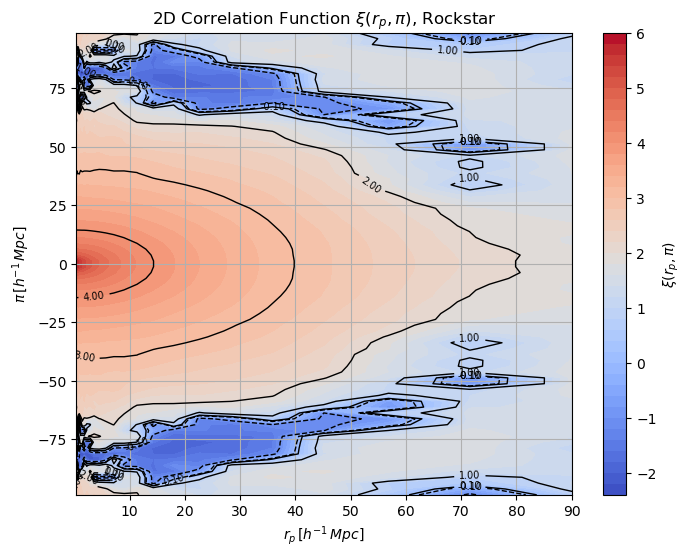

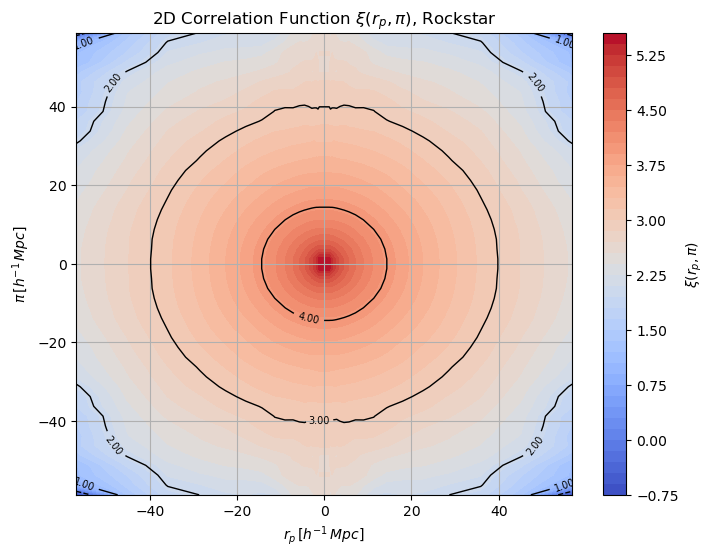

In [49]:
print_xi(results_rppi_rs, pi_lim=100, r_lim=0.3, title='Rockstar')

# print_xi_round_test_nolog(results_rppi_cs, pi_lim=50, r_lim=50, r_lim_min=0.5, title='CompaSO')

print_xi_round(results_rppi_rs, pi_lim=60, r_lim=60, r_lim_min=1, title='Rockstar')


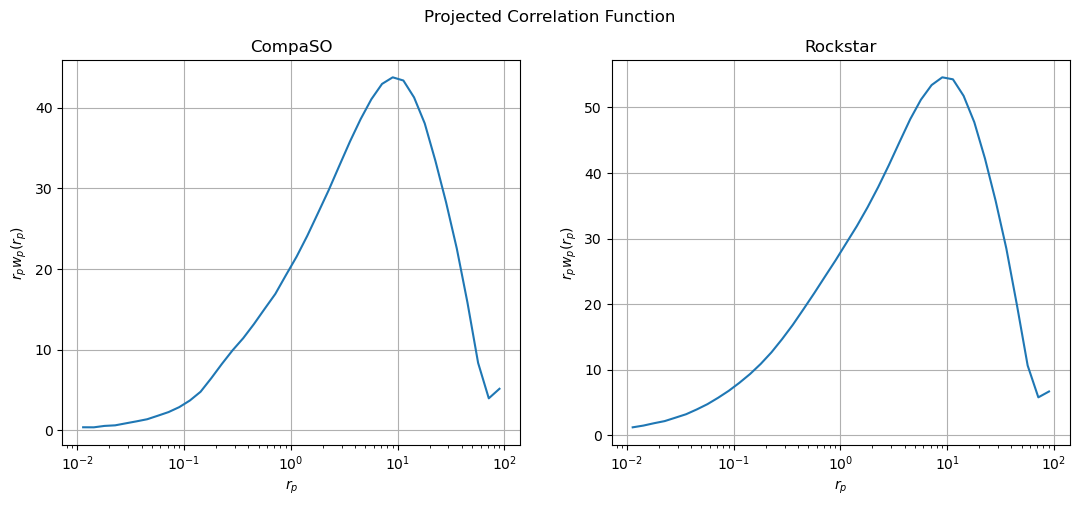

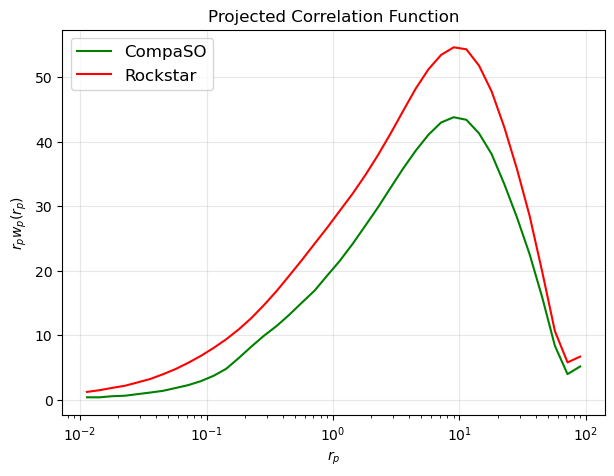

In [50]:
sep_rs, wp_rs = results_rppi_rs(pimax=None, return_sep=True) # sep is r_p
sep_cs, wp_cs = results_rppi_cs(pimax=None, return_sep=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharex=False, sharey=False, figsize=(13, 5))
fig.suptitle(f'Projected Correlation Function')

ax1.plot(sep_cs, sep_cs * wp_cs)
ax1.set_xscale('log')
ax1.set_xlabel(r'$r_{p}$')
ax1.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax1.set_title("CompaSO")
ax1.grid(True)

ax2.plot(sep_rs, sep_rs * wp_rs)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel(r'$r_{p}$')
ax2.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax2.set_title("Rockstar")
ax2.grid(True)

plt.show()

plt.figure(figsize=(7, 5))
plt.title(f'Projected Correlation Function')

# Plot CompaSO
plt.plot(sep_cs, sep_cs * wp_cs, label='CompaSO', color='green', linestyle='-')

# Plot Rockstar
plt.plot(sep_rs, sep_rs * wp_rs, label='Rockstar', color='red', linestyle='-')

# Axes and labels
plt.xscale('log')
plt.xlabel(r'$r_{p}$')
plt.ylabel(r'$r_{p} w_{p}(r_{p})$')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

### RSD

Shape of velocities: (14505043, 3)
Shape of positions: (14505043, 3) 

Hubble constant Hz: 132.23392151789199 



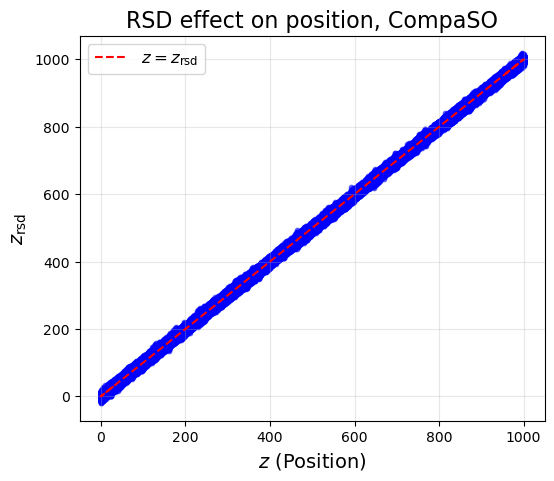

Hz : 131.54618960654088 
 Om_rs : 0.315192 
 Ol_rs : 0.666667 
 z_sim_rs : 0.5 
 a_rs : 0.666667 

Shape of velocities: (32390403, 3)
Shape of positions: (32390403, 3) 

Hubble constant Hz: 131.54618960654088 



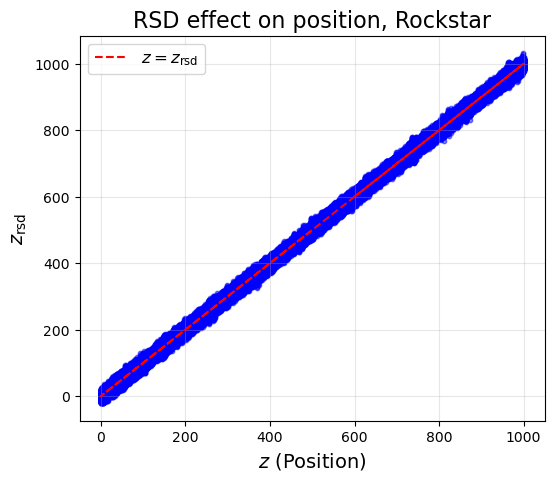

In [51]:
## CompaSO

z_sim_cs = hcat.header['Redshift']
id_cs = np.array(sampled_halos_cs['id'])
a_cs = hcat.header['ScaleFactor'] # scale factor

Hz_cs = hcat.header['HubbleNow'] * 100

velocities_cs = np.array(sampled_halos_cs['v_L2com'])

z_rsd_cs, delta_z_cs = rsd_effect(a_cs, positions_cs, velocities_cs, Hz_cs, name='CompaSO')

## Rockstar

H0 = 100
Om_rs = get_variable(file_path_rs, name='Om')
Ol_rs = get_variable(file_path_rs, name='Ol')
z_sim_rs = extract_redshift_from_path(file_path_rs)
a_rs = Ol_rs = get_variable(file_path_rs, name='SCALE_NOW')

Hz_rs = H0 * np.sqrt(Om_rs * (1+z_sim_rs)**3 + Ol_rs)

print('Hz :', Hz_rs, '\n', 'Om_rs :', Om_rs, '\n', 'Ol_rs :', Ol_rs, '\n', 'z_sim_rs :', z_sim_rs, '\n', 'a_rs :', a_rs, '\n',)

z_rsd_rs, delta_z_rs = rsd_effect(a_rs, sampled_positions_rs, sampled_velocities_rs, Hz_rs, name='Rockstar')


In [52]:
# ## CompaSo

# results_rppi_cs_rsd = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_cs, y_cs, z_rsd_cs),  # Positions des halos
#     nthreads=25,
#     boxsize=boxsize_cs,
#     los='z'
# )

# pi_cs_rsd = results_rppi_cs_rsd.sepavg(axis=1)
# xi_rppi_cs_rsd = results_rppi_cs_rsd.corr

In [53]:
# np.savez('/pscratch/sd/g/guittonm/rppi_cs_rsd.npz', 
#          results_rppi_cs_rsd=results_rppi_cs_rsd,
#          pi_cs_rsd=pi_cs_rsd, 
#          xi_rppi_cs_rsd=xi_rppi_cs_rsd)

data_rppi_cs_rsd = np.load('/pscratch/sd/g/guittonm/rppi_cs_rsd.npz', allow_pickle=True)

results_rppi_cs_rsd = data_rppi_cs_rsd['results_rppi_cs_rsd'].item()
pi_cs_rsd = data_rppi_cs_rsd['pi_cs_rsd']
xi_rppi_cs_rsd = data_rppi_cs_rsd['xi_rppi_cs_rsd']

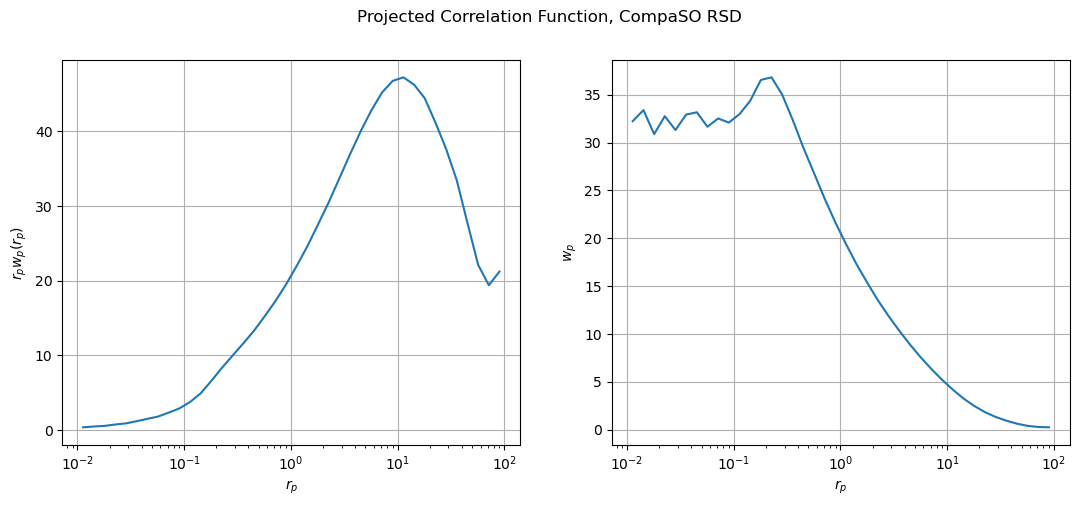

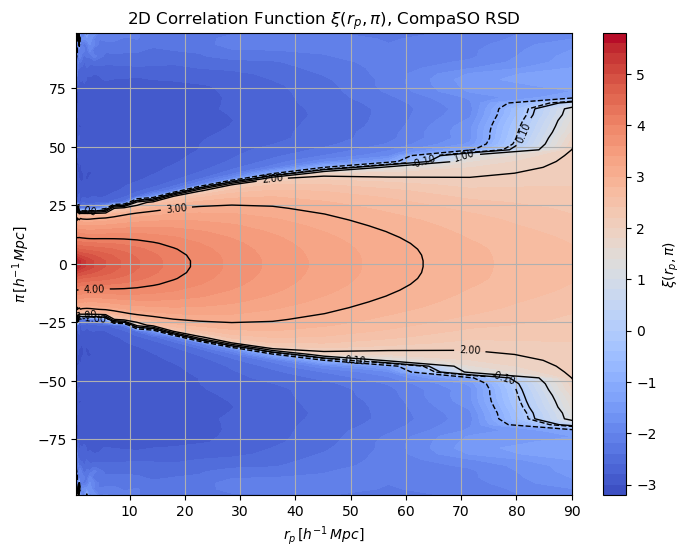

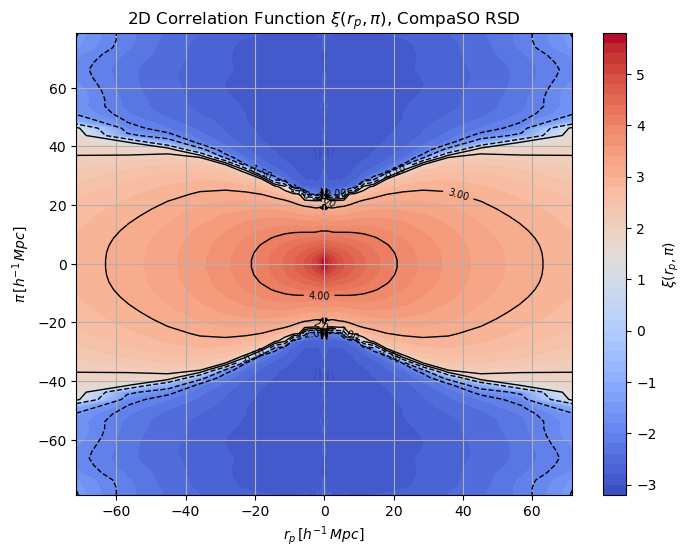

In [54]:
sep_cs_rsd = projected_pcf(results_rppi_cs_rsd, title='CompaSO RSD')

print_xi(results_rppi_cs_rsd, pi_lim=100, r_lim=0.3, title='CompaSO RSD')
print_xi_round(results_rppi_cs_rsd, pi_lim=80, r_lim=80, r_lim_min=0.3, title='CompaSO RSD')

In [55]:
# ## Rockstar

# results_rppi_rs_rsd = TwoPointCorrelationFunction(
#     mode='rppi',  
#     edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
#     data_positions1=(x_rs, y_rs, z_rsd_rs),  # Positions des halos
#     nthreads=25,
#     boxsize=boxsize_rs,
#     los='z'
# )

# pi_rs_rsd = results_rppi_rs_rsd.sepavg(axis=1)
# xi_rppi_rs_rsd = results_rppi_rs_rsd.corr

In [56]:
# np.savez('/pscratch/sd/g/guittonm/rppi_rs_rsd.npz', 
#          results_rppi_rs_rsd=results_rppi_rs_rsd,
#          pi_rs_rsd=pi_rs_rsd, 
#          xi_rppi_rs_rsd=xi_rppi_rs_rsd)

data_rppi_rs_rsd = np.load('/pscratch/sd/g/guittonm/rppi_rs_rsd.npz', allow_pickle=True)

results_rppi_rs_rsd = data_rppi_rs_rsd['results_rppi_rs_rsd'].item()
pi_rs_rsd = data_rppi_rs_rsd['pi_rs_rsd']
xi_rppi_rs_rsd = data_rppi_rs_rsd['xi_rppi_rs_rsd']

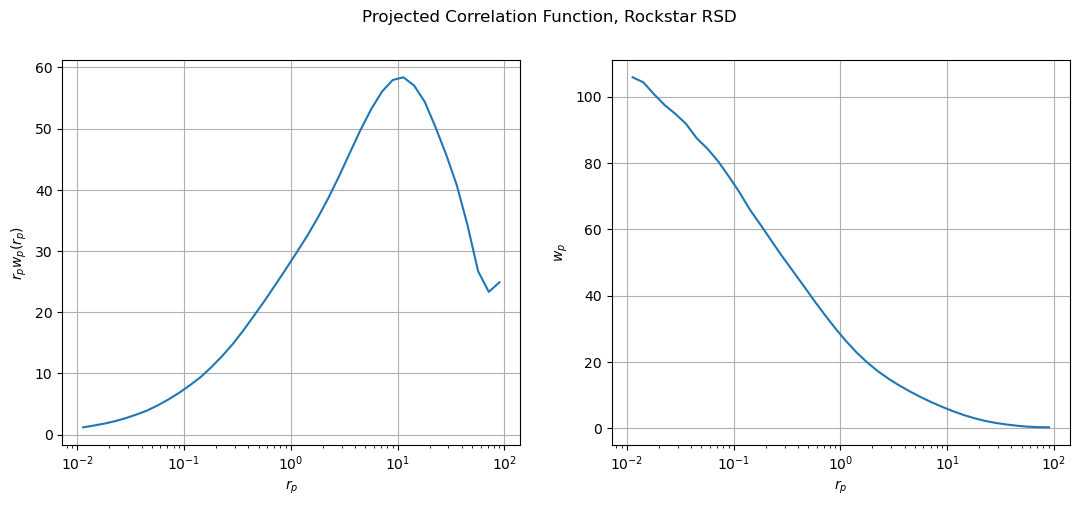

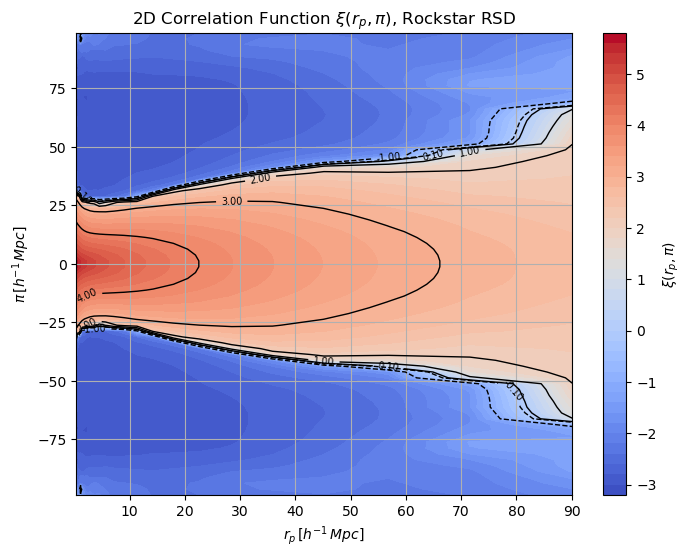

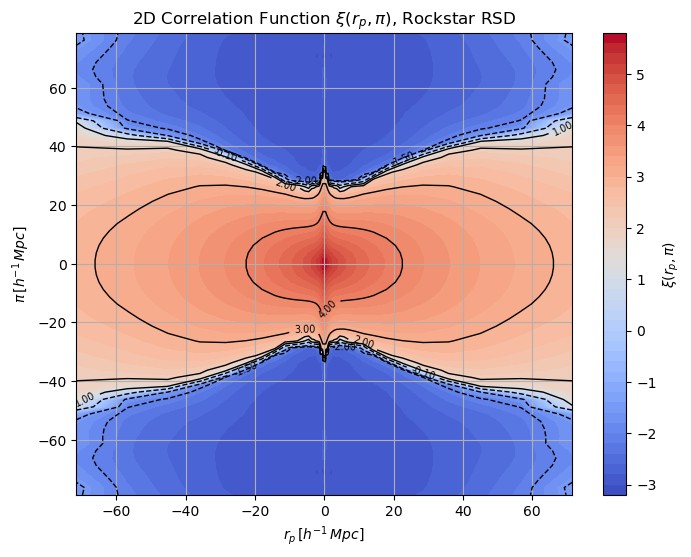

In [57]:
sep_rs_rsd = projected_pcf(results_rppi_rs_rsd, title='Rockstar RSD')

print_xi(results_rppi_rs_rsd, pi_lim=100, r_lim=0.3, title='Rockstar RSD')
print_xi_round(results_rppi_rs_rsd, pi_lim=80, r_lim=80, r_lim_min=0.3, title='Rockstar RSD')

### 2PCF comparison

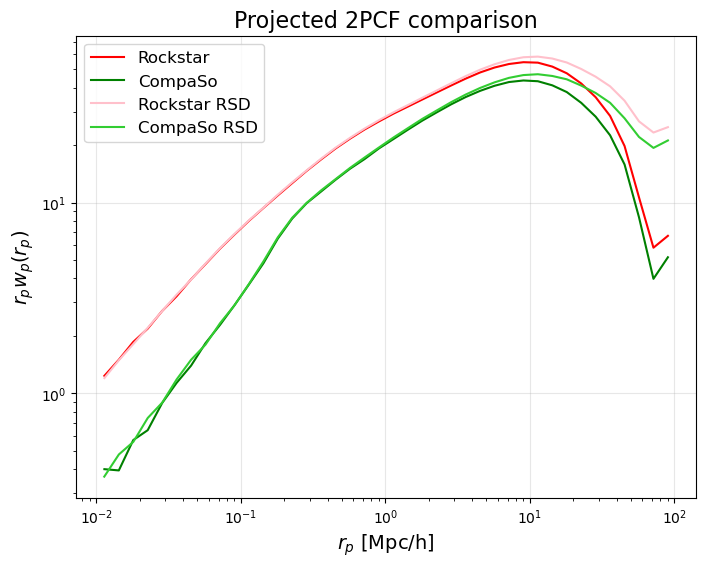

In [58]:
pcf_results = [results_rppi_rs, results_rppi_cs, results_rppi_rs_rsd, results_rppi_cs_rsd]
legends_pcf = ['Rockstar', 'CompaSo', 'Rockstar RSD', 'CompaSo RSD']
colors_pcf= ['red', 'green', 'pink', 'limegreen']

compa_pcf(pcf_results, legends=legends_pcf, colors=colors_pcf, title="Projected 2PCF comparison", mask_range=(0.01,100))

# Bias

In [59]:
fraction = 0.02  # % of the data

# Create a binary mask to select 10% of the data
mask = np.random.rand(positions_mm.shape[0]) < fraction
 
# Apply the mask
positions_mm_sampled = positions_mm[mask]

if positions_mm_sampled.shape[1] == 3:  # Check that it's a 2D table with 3 columns
    positions_mm_sampled = [positions_mm_sampled[:, 0], positions_mm_sampled[:, 1], positions_mm_sampled[:, 2]]  # Separate x, y, z

In [60]:
# ## SMU

# results_smu_mm = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Distance markers for bins
#     data_positions1=positions_mm_sampled,  # Particles positions
#     boxsize=boxsize_cs,  
#     los='z',
#     nthreads=45
# )

# xi_mm = results_smu_mm.corr  

In [60]:
# np.savez('/pscratch/sd/g/guittonm/smu_mm.npz', 
#          results_smu_mm=results_smu_mm,
#          xi_mm=xi_mm)    
 
data_smu_mm = np.load('/pscratch/sd/g/guittonm/smu_mm.npz', allow_pickle=True)
 
results_smu_mm = data_smu_mm['results_smu_mm'].item()  
xi_mm = data_smu_mm['xi_mm'] 

## Quadrupoles

In [61]:
r_cs_quad, xi_cs_quad = results_smu_cs(ells=(2,), return_sep=True)
r_rs_quad, xi_rs_quad = results_smu_rs(ells=(2,), return_sep=True)
r_mm_quad, xi_mm_quad = results_smu_mm(ells=(2,), return_sep=True)

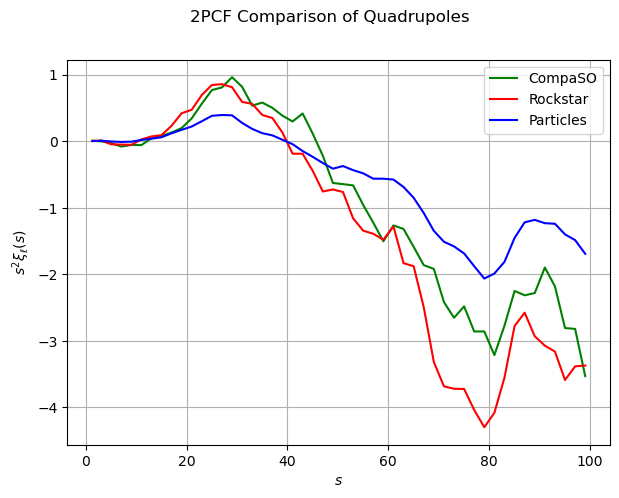

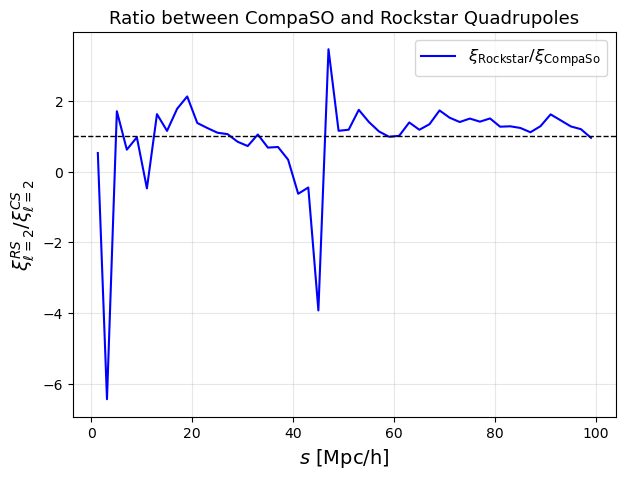

In [62]:
print_chosen_multipole(
    [r_cs_quad, r_rs_quad, r_mm_quad], 
    [xi_cs_quad, xi_rs_quad, xi_mm_quad], 
    ["CompaSO", "Rockstar", "Particles"], 
    "Quadrupoles",
    colors_list = ['green', 'red', 'blue']
)

plot_multipole_ratio(r_cs_quad, xi_cs_quad, xi_rs_quad, yrange=None, mask_range=None, l='2', title = "Ratio between CompaSO and Rockstar Quadrupoles", label=r"$\xi_{\mathrm{Rockstar}} / \xi_{\mathrm{CompaSo}}$")

## Bias 

In [63]:
bin_edges_exp = [11, 11.2, 11.4, 11.6, 11.8, 12, 12.5, 13, 15]

mass_bins = np.power(10, bin_edges_exp)

In [64]:
print(mass_bins)

[1.00000000e+11 1.58489319e+11 2.51188643e+11 3.98107171e+11
 6.30957344e+11 1.00000000e+12 3.16227766e+12 1.00000000e+13
 1.00000000e+15]


### All halos

In [65]:
## CompaSo

positions_cs_all = np.array(hcat_filtered['x_L2com'])
positions_cs_all = positions_cs_all.astype(np.float64)

print("Shape of positions:", positions_cs_all.shape)
x_cs_all, y_cs_all, z_cs_all = positions_cs_all[:, 0], positions_cs_all[:, 1], positions_cs_all[:, 2]

## Rockstar

# positions_RS

Shape of positions: (48359672, 3)


In [66]:
# print('CompaSo')
# bias_mono_cs, bias_quad_cs = bias_wrt_mass(mass_bins, Mhalos_filtered_CS, positions_cs_all, bins_s, bins_mu, boxsize_cs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs.npz")
# print('\n', 'Rockstar')
# bias_mono_rs, bias_quad_rs = bias_wrt_mass(mass_bins, Mhalos_filtered_RS, positions_RS, bins_s, bins_mu, boxsize_rs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs.npz")

In [67]:
# Charger le fichier .npz
data_cs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs.npz")
data_rs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs.files)
print(data_rs.files)

# Extraire les données
mass_bins_cs = data_cs["mass_bins"]  # Bins de masse
r_hh_all_cs = data_cs["r_hh_all"]  # Valeurs de r pour chaque bin
xi_hh_mono_all_cs = data_cs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
bias_by_r_mono_all_cs = data_cs["bias_by_r_mono_all"]
bias_mono_cs =  data_cs["bias_by_mass_mono"]

mass_bins_rs = data_rs["mass_bins"]  # Bins de masse
r_hh_all_rs = data_rs["r_hh_all"]  # Valeurs de r pour chaque bin
xi_hh_mono_all_rs = data_rs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
bias_by_r_mono_all_rs = data_rs["bias_by_r_mono_all"]
bias_mono_rs =  data_rs["bias_by_mass_mono"]

['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_mass_mono', 'bias_by_mass_quad', 'bias_by_r_mono_all', 'bias_by_r_quad_all']
['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_mass_mono', 'bias_by_mass_quad', 'bias_by_r_mono_all', 'bias_by_r_quad_all']


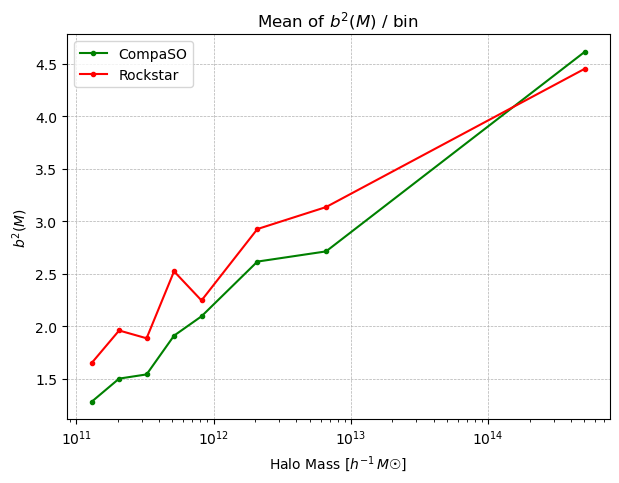

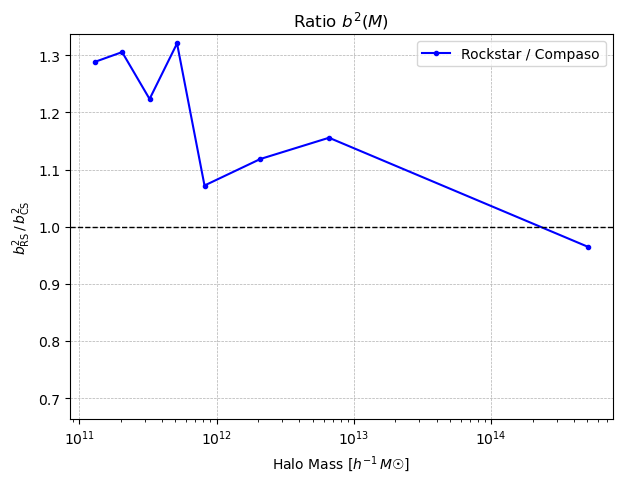

In [68]:
mass_centers_cs = [item[0] for item in bias_mono_cs]
bias_values_cs = [item[1] for item in bias_mono_cs]

mass_centers_rs = [item[0] for item in bias_mono_rs]
bias_values_rs = [item[1] for item in bias_mono_rs]

plot_masses_fct(data_list = [bias_values_cs, bias_values_rs],
                bins_list = [mass_centers_cs, mass_centers_rs],
                colors_list = colors_list,
                labels_list = labels_name,
                linestyles_list=['-','-'],
                ylabel = r'$b^2(M)$',
                title=r"Mean of $b^2(M)$ / bin",
                scale = 'semilogx', center_around_one=False)

np_bias_values_rs = np.array(bias_values_rs)
np_bias_values_cs = np.array(bias_values_cs)

bias_ratio = np_bias_values_rs / np_bias_values_cs

plot_masses_fct(data_list = [bias_ratio],
                bins_list = [mass_centers_rs],
                colors_list = colors_ratio,
                labels_list = labels_ratio,
                linestyles_list=['-'],
                ylabel = r'$b^2_{\mathrm{RS}} \,/\, b^2_{\mathrm{CS}}$',
                title = r"Ratio $b^2(M)$",
                scale = 'semilogx', center_around_one=True)

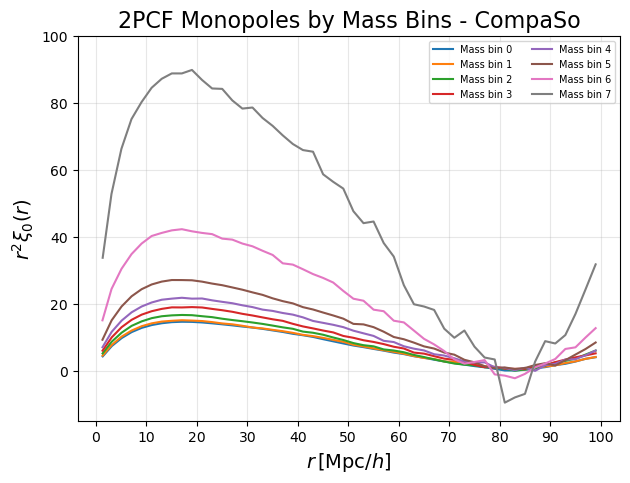

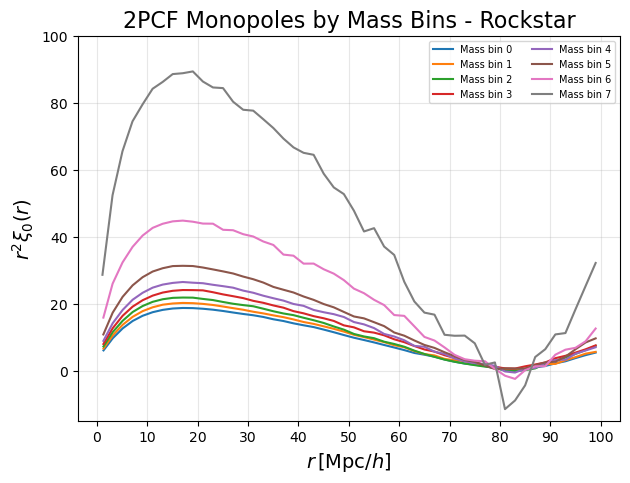

In [69]:
## CompaSo

plot_mass_binned_quantity(
    r_hh_all=r_hh_all_cs, 
    quantity_all=xi_hh_mono_all_cs,  
    mass_bins=mass_bins,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title='2PCF Monopoles by Mass Bins - CompaSo',
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation spécifique pour la 2PCF
    mask_range=(0,100),
    yrange=(-15,100),
    scalex=None,
    scaley=None
)

## Rockstar 

plot_mass_binned_quantity(
    r_hh_all=r_hh_all_rs, 
    quantity_all=xi_hh_mono_all_rs,  
    mass_bins=mass_bins,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title='2PCF Monopoles by Mass Bins - Rockstar',
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation spécifique pour la 2PCF
    mask_range=(0,100),
    yrange=(-15,100),
    scalex=None,
    scaley=None
)

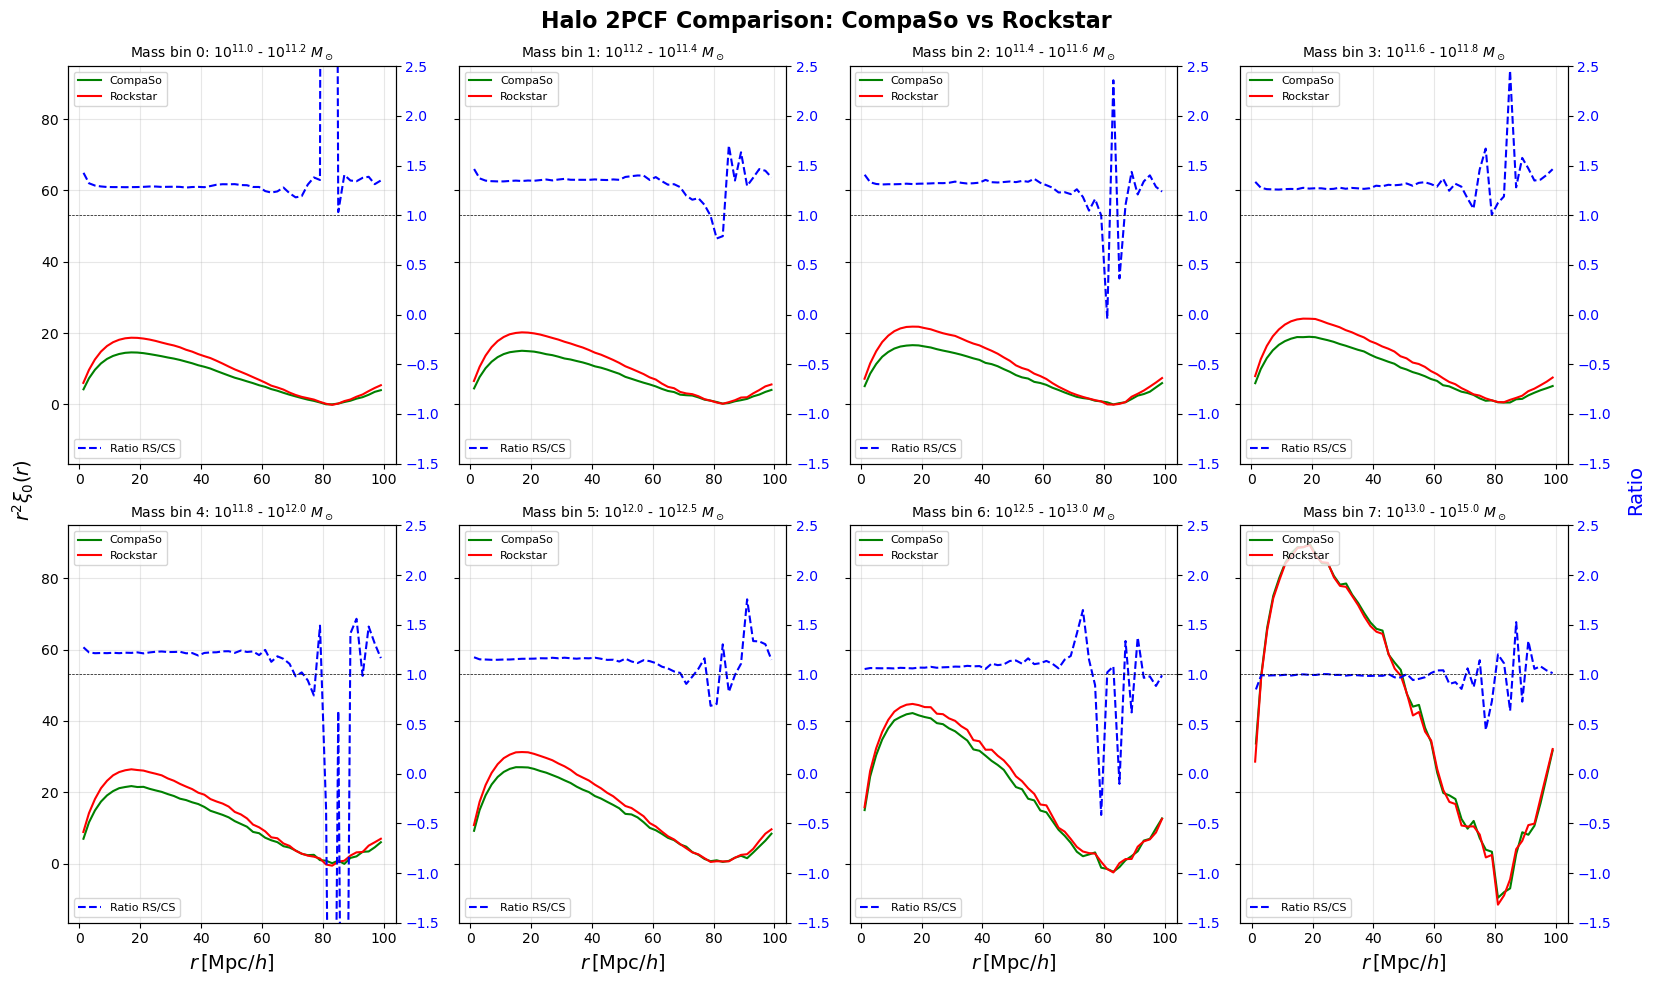

In [70]:
plot_mass_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs, quantity_all_cs=xi_hh_mono_all_cs, errors_cs=False,
    r_hh_all_rs=r_hh_all_rs, quantity_all_rs=xi_hh_mono_all_rs, errors_rs=False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title="Halo 2PCF Comparison: CompaSo vs Rockstar",
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation pour la 2PCF
    rows=2,  # Affichage sur 2 lignes,
    mask_range=(0,100), ratio_yrange=(-1.5,2.5),
    scaley=None,
    scalex=None
)

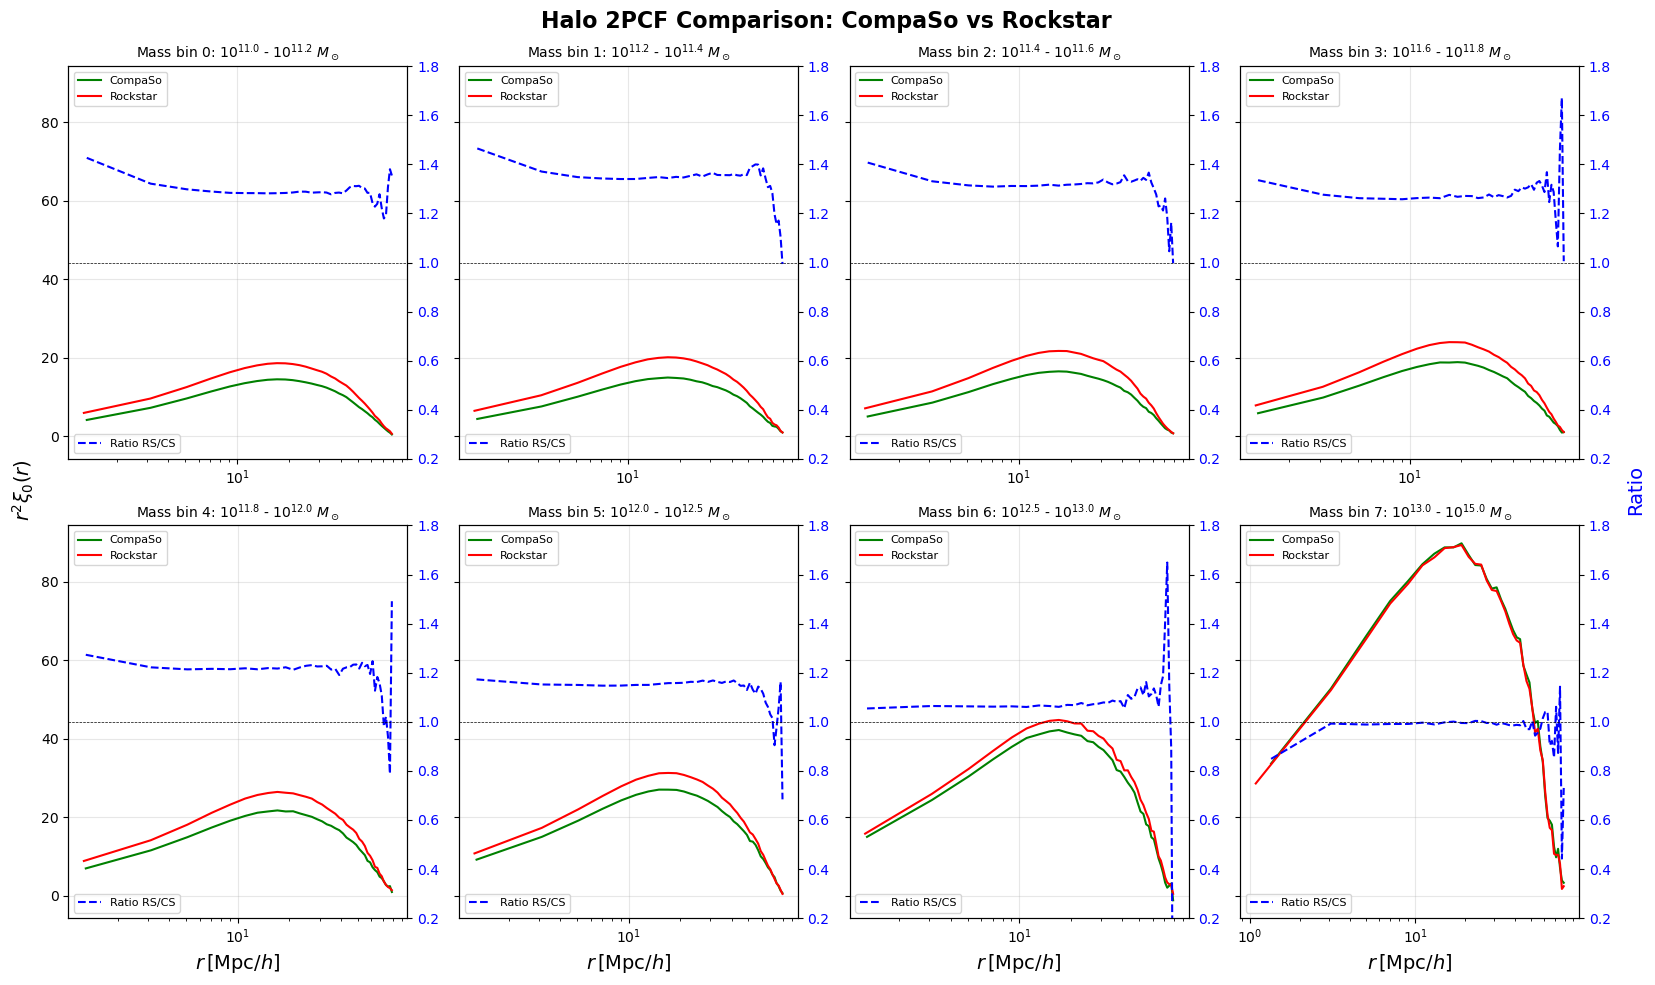

In [71]:
plot_mass_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs, quantity_all_cs=xi_hh_mono_all_cs, errors_cs=False,
    r_hh_all_rs=r_hh_all_rs, quantity_all_rs=xi_hh_mono_all_rs, errors_rs=False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r^2 \xi_{0}(r)$',
    title="Halo 2PCF Comparison: CompaSo vs Rockstar",
    apply_transformation=lambda r, q: r * r * q.squeeze(),  # Transformation pour la 2PCF
    rows=2,  # Affichage sur 2 lignes,
    mask_range=(0,80), ratio_yrange=(0.2,1.8),
    scaley=None,
    scalex='log'
)

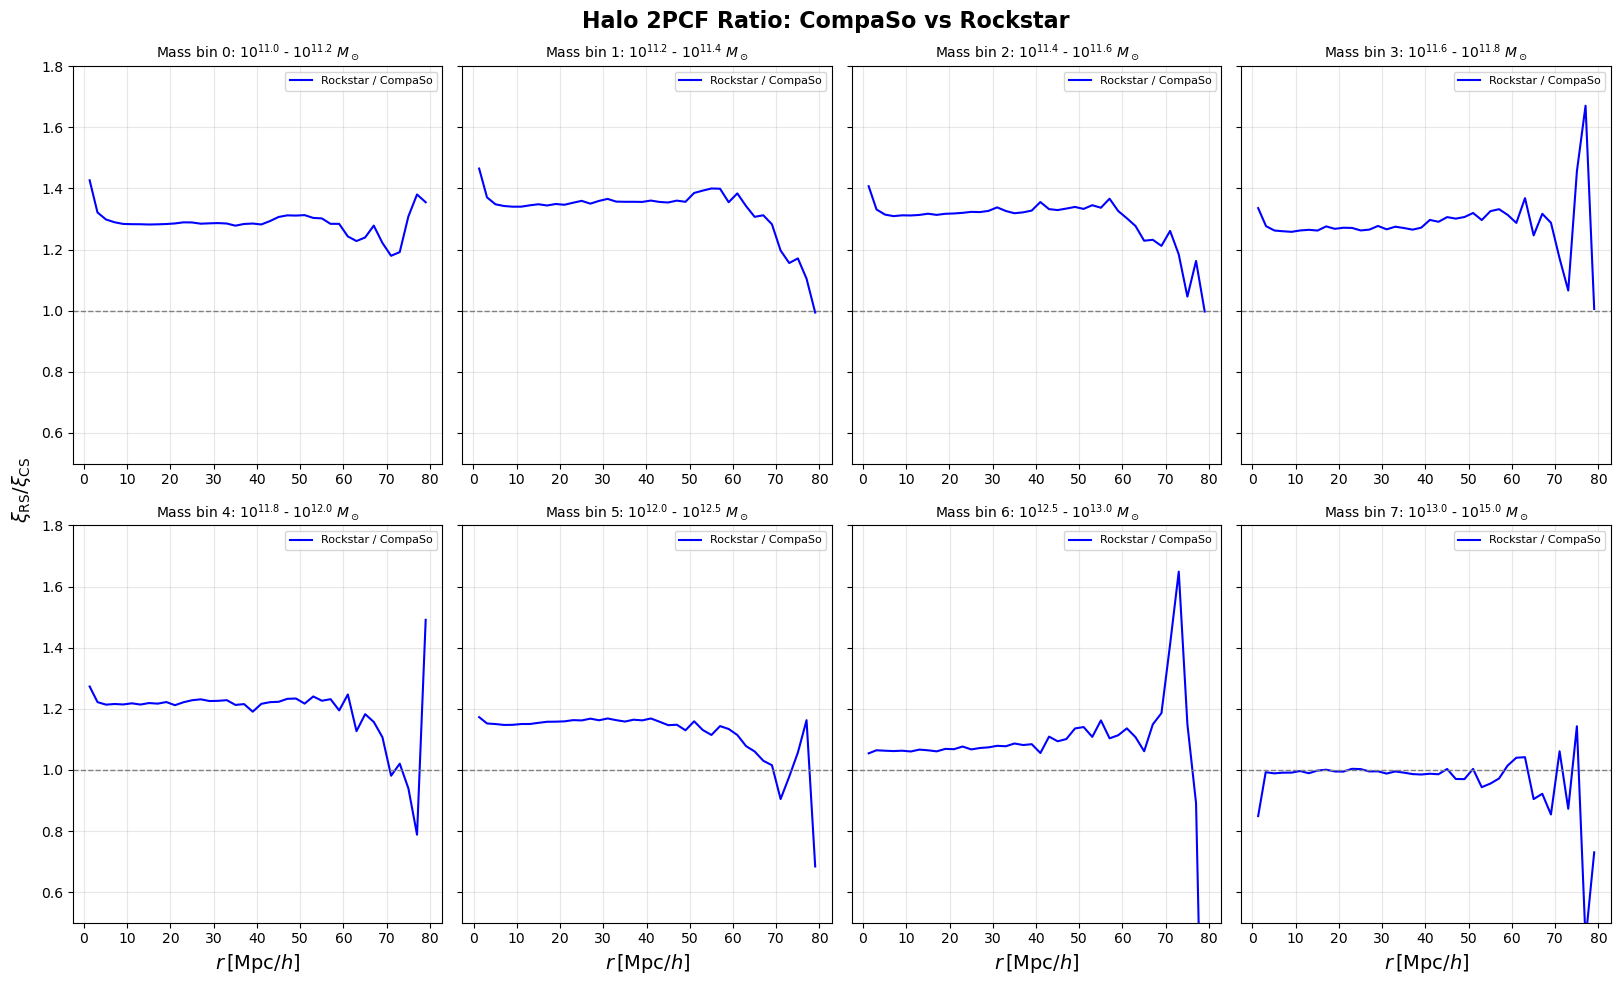

In [72]:
plot_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs, quantity_all_cs=xi_hh_mono_all_cs,
    r_hh_all_rs=r_hh_all_rs, quantity_all_rs=xi_hh_mono_all_rs,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$\xi_{\mathrm{RS}} / \xi_{\mathrm{CS}}$',
    title="Halo 2PCF Ratio: CompaSo vs Rockstar",
    apply_transformation=lambda r, q: r * r * q.squeeze(),
    yrange=(0.5, 1.8),
    mask_range=(0,80),
    rows=2  # Affichage sur 2 lignes
)

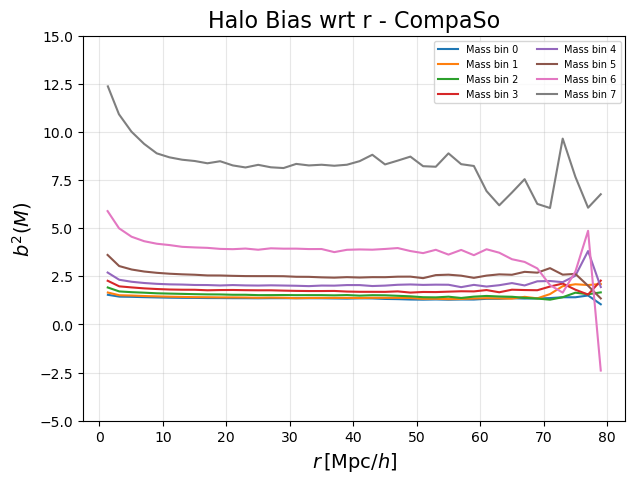

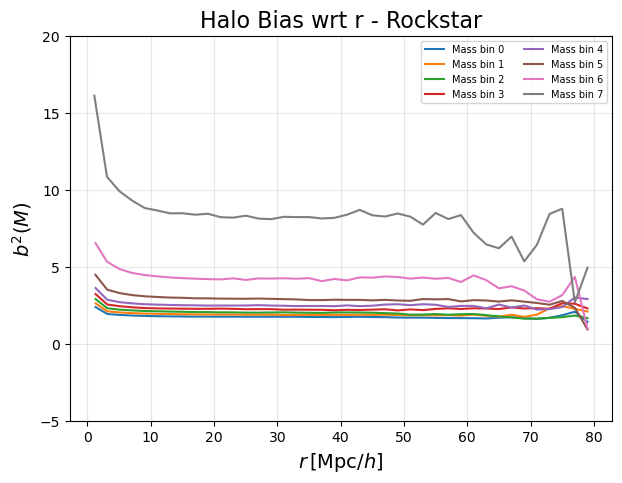

In [73]:
## CompaSo
plot_mass_binned_quantity(
    r_hh_all=r_hh_all_cs, 
    quantity_all=bias_by_r_mono_all_cs,  
    mass_bins=mass_bins,
    ylabel=r'$b^2(M)$',
    title='Halo Bias wrt r - CompaSo',
    mask_range=(0,80),
    yrange=(-5,15),
    scalex=None,
    scaley=None
)

## Rockstar
plot_mass_binned_quantity(
    r_hh_all=r_hh_all_rs, 
    quantity_all=bias_by_r_mono_all_rs,  
    mass_bins=mass_bins,
    ylabel=r'$b^2(M)$',
    title='Halo Bias wrt r - Rockstar',
    mask_range=(0,80),
    yrange=(-5,20),
    scalex=None,
    scaley=None
)

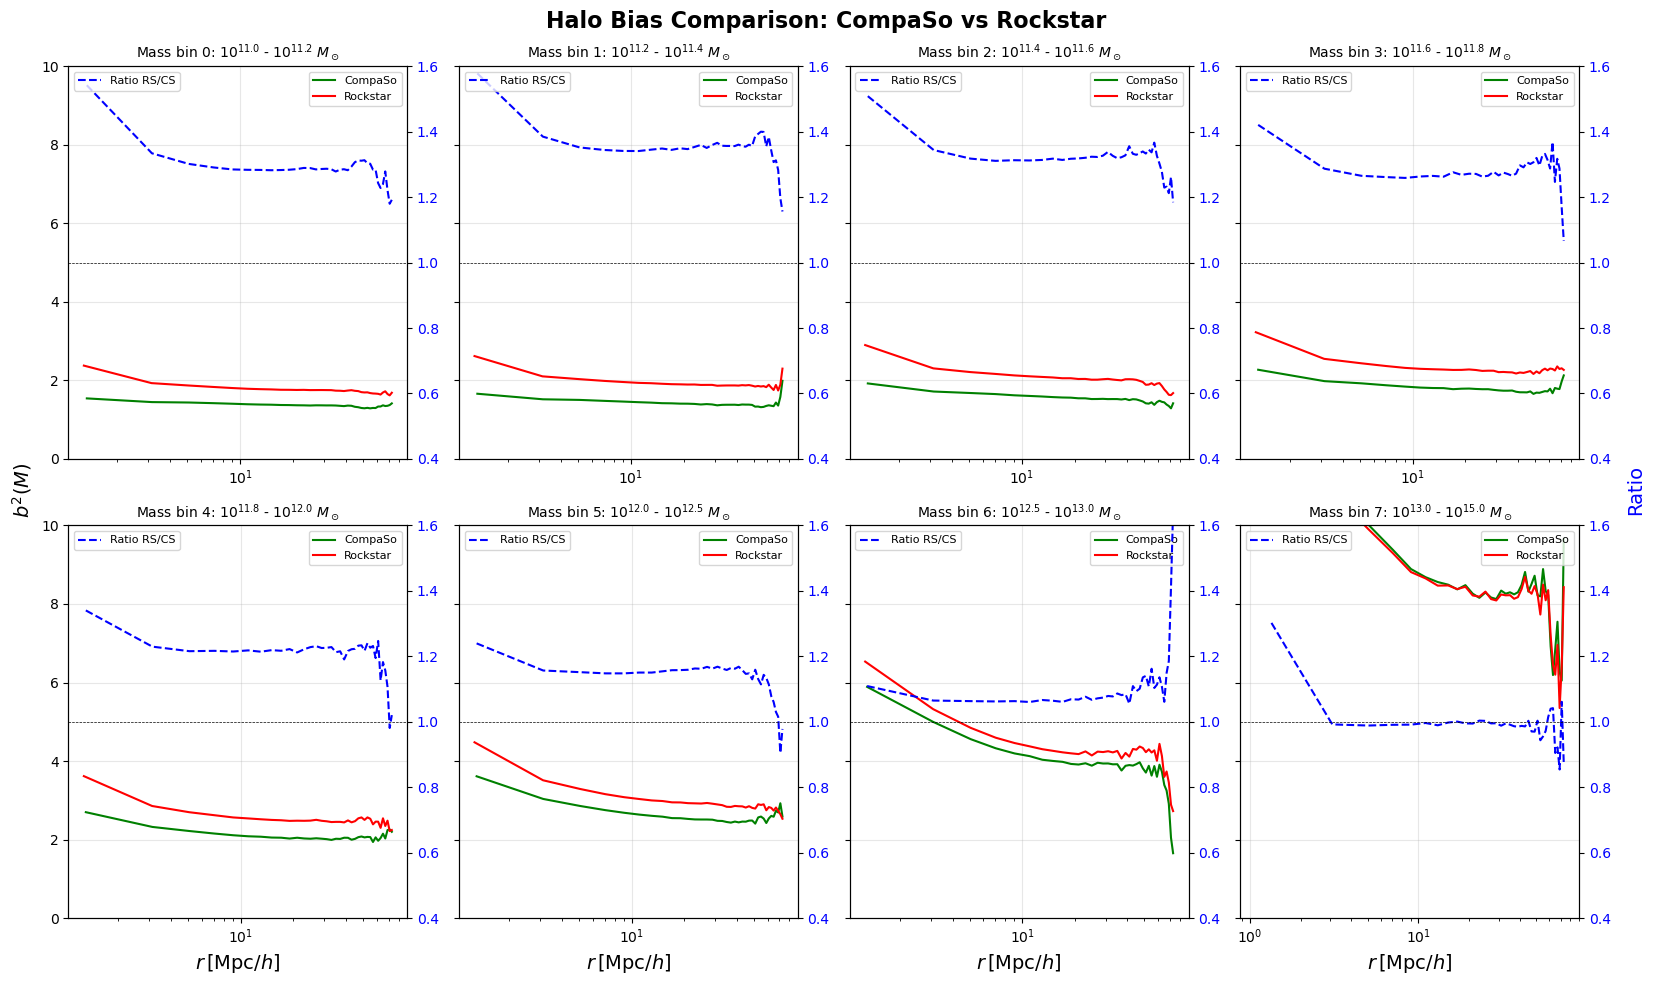

In [105]:
plot_mass_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs, quantity_all_cs=bias_by_r_mono_all_cs, errors_cs=False,
    r_hh_all_rs=r_hh_all_rs, quantity_all_rs=bias_by_r_mono_all_rs, errors_rs=False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2(M)$',
    title="Halo Bias Comparison: CompaSo vs Rockstar",
    rows=2, ratio_leg='upper left', leg_pos='upper right',
    yrange = (0, 10), ratio_yrange=(0.4,1.6),
    mask_range = (0, 75), scaley=None
)

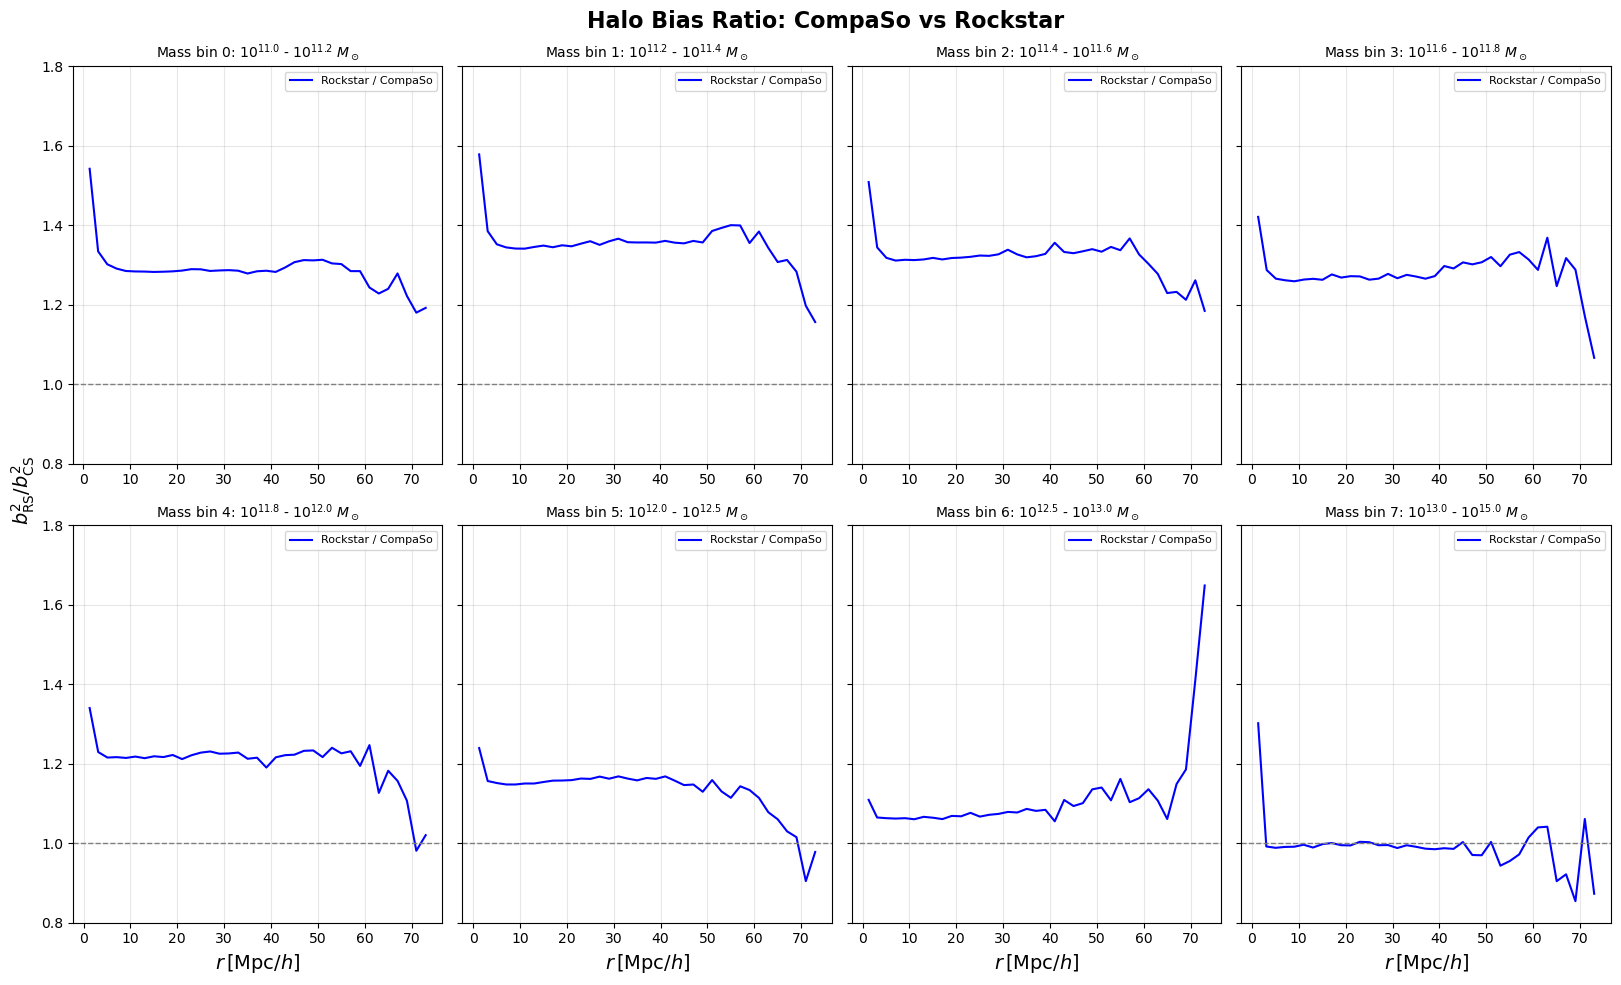

In [75]:
plot_ratio_comparison(
    r_hh_all_cs=r_hh_all_cs, quantity_all_cs=bias_by_r_mono_all_cs,
    r_hh_all_rs=r_hh_all_rs, quantity_all_rs=bias_by_r_mono_all_rs,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2_{\mathrm{RS}} / b^2_{\mathrm{CS}}$',
    title="Halo Bias Ratio: CompaSo vs Rockstar",
    yrange=(0.8, 1.8),
    mask_range=(0,75),
    rows=2  # Affichage sur 2 lignes
)

### RPPI per mass bin

In [76]:
# wp_all_cs, rp_all_cs = xi_wrt_mass(mass_bins, Mhalos_filtered_CS, positions_cs_all, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_cs_bs.npz", mask_range=(None, None), nthreads=32)

# wp_all_rs, rp_all_rs = xi_wrt_mass(mass_bins, Mhalos_filtered_RS, positions_RS, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_rs_bs.npz", mask_range=(None, None), nthreads=32)

In [77]:
# Charger le fichier .npz
data_cs_rppi = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_cs_bs.npz")
data_rs_rppi = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_rs_bs.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_rppi.files)
print(data_rs_rppi.files)

# Extraire les données
mass_bins_cs_rppi = data_cs_rppi["mass_bins"]  # Bins de masse
rp_all_cs = data_cs_rppi["rp_all"] 
wp_all_cs = data_cs_rppi["wp_all"] 

mass_bins_rs_rppi = data_rs_rppi["mass_bins"]  # Bins de masse
rp_all_rs = data_rs_rppi["rp_all"]  
wp_all_rs = data_rs_rppi["wp_all"]

['mass_bins', 'rp_all', 'wp_all']
['mass_bins', 'rp_all', 'wp_all']


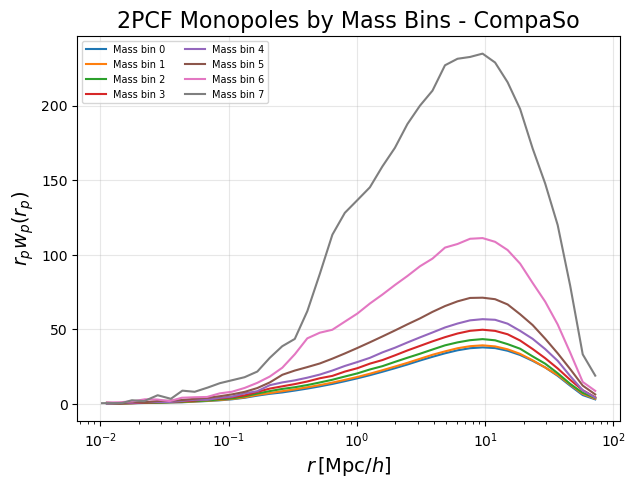

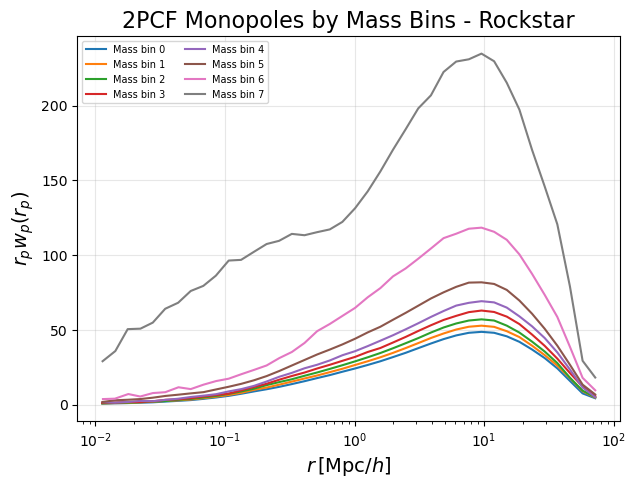

In [78]:
plot_mass_binned_quantity(
    r_hh_all=rp_all_cs, 
    quantity_all=wp_all_cs,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins - CompaSo',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

plot_mass_binned_quantity(
    r_hh_all=rp_all_rs, 
    quantity_all=wp_all_rs,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins - Rockstar',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

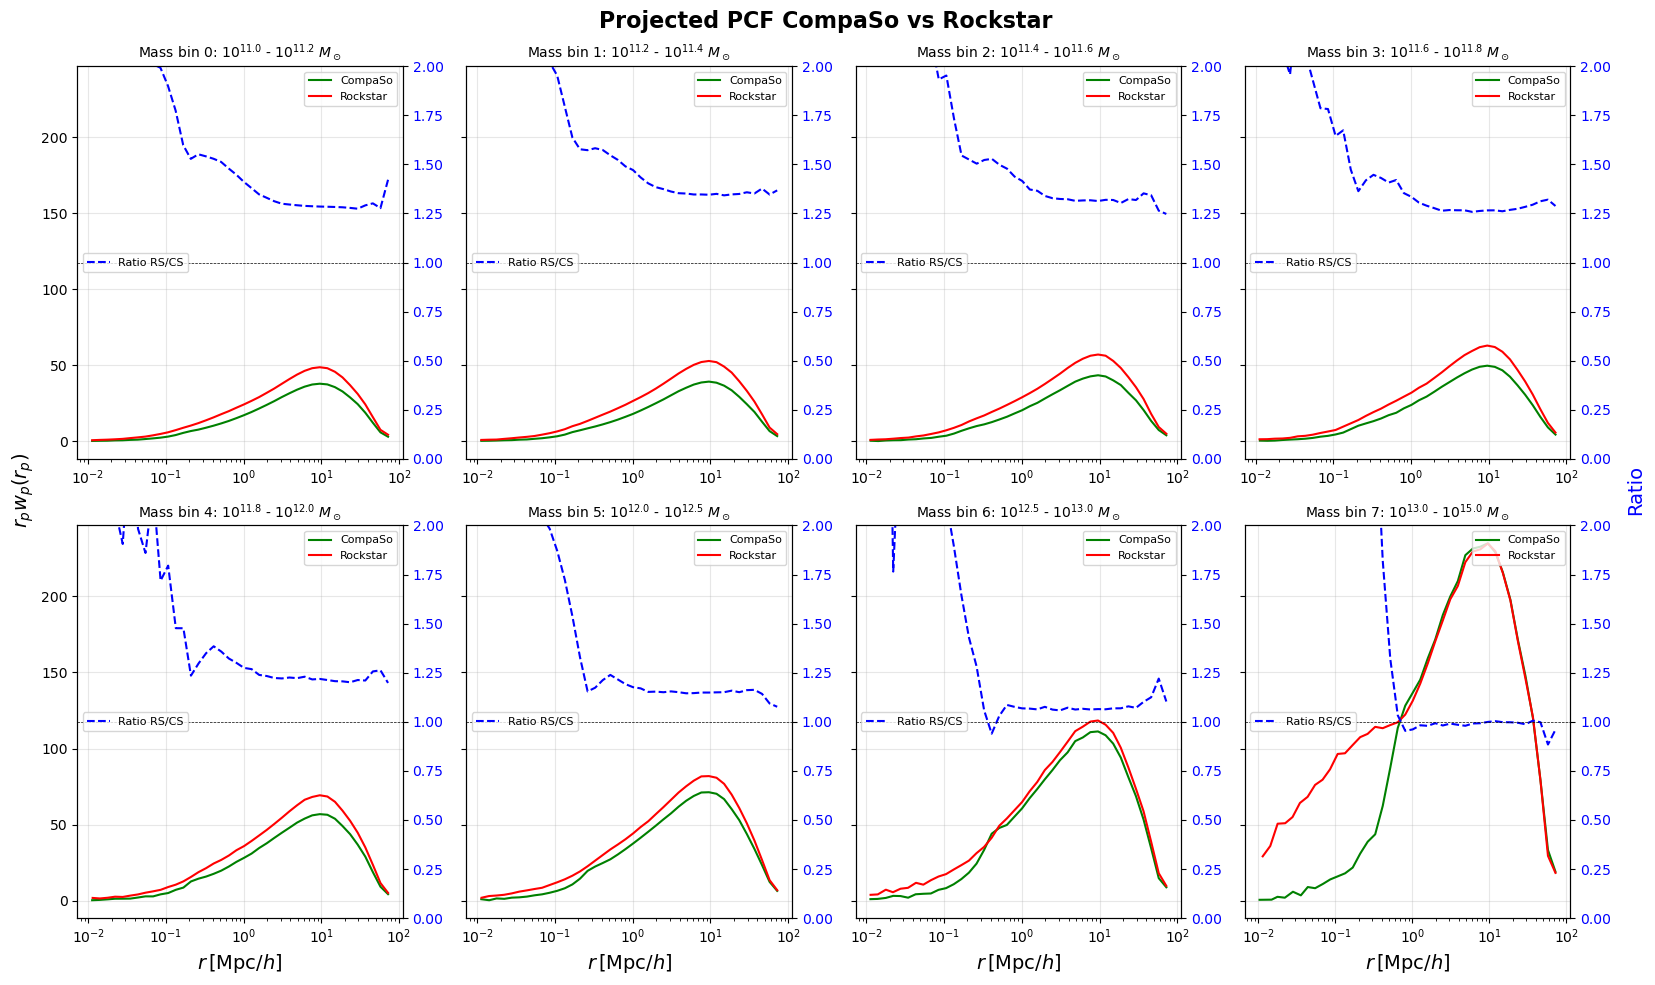

In [101]:
plot_mass_ratio_comparison(
    r_hh_all_cs=rp_all_cs, quantity_all_cs=wp_all_cs, errors_cs = False,
    r_hh_all_rs=rp_all_rs, quantity_all_rs=wp_all_rs, errors_rs = False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title="Projected PCF CompaSo vs Rockstar",
    rows=2, ratio_leg='center left', leg_pos ='upper right',
    apply_transformation=lambda r, q: r * q.squeeze(),
    scalex='log',
    scaley=None, ratio_yrange=(0,2)
)

Shape of velocities: (48359672, 3)
Shape of positions: (48359672, 3) 

Hubble constant Hz: 132.23392151789199 



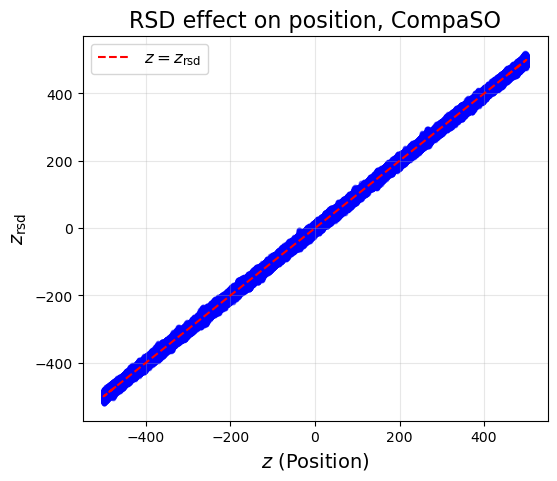

Shape of velocities: (107967449, 3)
Shape of positions: (107967449, 3) 

Hubble constant Hz: 132.23392151789199 



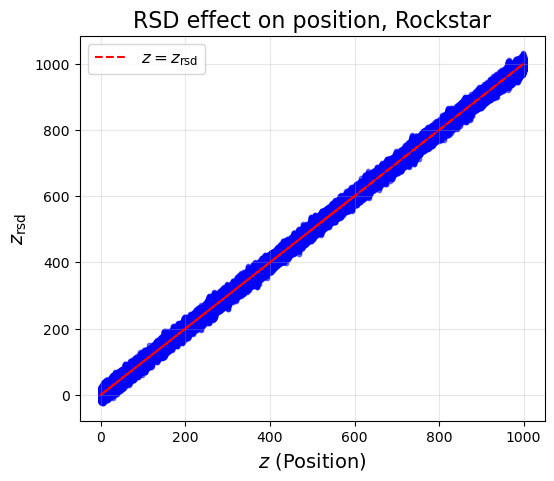

Mass bin 0: 12895938 halos
Nombre de halos dans le bin : 12895938
Nombre de bins rp: 41
Nombre de bins pi: 81
Nombre total de halos dans le bin 0: 12895938
Nombre de bins_rp: 41, Nombre de bins_pi: 81
Min bins_rp: 0.01, Max bins_rp: 100.0
Type de rp: <class 'numpy.ndarray'>
Shape de rp: (40,)
0
0
Min rp: 0.01134634333060203
Max rp: 90.10924486572596
Min bins_rp: 0.01
Max bins_rp: 100.0
40
Mass bin 1: 8207765 halos
Nombre de halos dans le bin : 8207765
Nombre de bins rp: 41
Nombre de bins pi: 81
Nombre total de halos dans le bin 1: 8207765
Nombre de bins_rp: 41, Nombre de bins_pi: 81
Min bins_rp: 0.01, Max bins_rp: 100.0
Type de rp: <class 'numpy.ndarray'>
Shape de rp: (40,)
0
0
Min rp: 0.011320372885405435
Max rp: 90.10913952580282
Min bins_rp: 0.01
Max bins_rp: 100.0
40
Mass bin 2: 5298816 halos
Nombre de halos dans le bin : 5298816
Nombre de bins rp: 41
Nombre de bins pi: 81
Nombre total de halos dans le bin 2: 5298816
Nombre de bins_rp: 41, Nombre de bins_pi: 81
Min bins_rp: 0.01, M

In [ ]:
# ## RSD

# x_cs_all, y_cs_all, z_cs_all = positions_cs_all[:, 0], positions_cs_all[:, 1], positions_cs_all[:, 2]
# x_rs_all, y_rs_all, z_rs_all = positions_RS[:, 0], positions_RS[:, 1], positions_RS[:, 2]

# velocities_all_cs =  np.array(hcat_filtered['v_L2com'])
# z_rsd_all_cs, delta_z_all_cs = rsd_effect(a_cs, positions_cs_all, velocities_all_cs, Hz_cs, name='CompaSO')
# z_rsd_all_rs, delta_z_all_rs = rsd_effect(a_rs, positions_RS, velocities_RS, Hz_cs, name='Rockstar' )

# positions_cs_rsd = np.vstack((x_cs_all, y_cs_all, z_rsd_all_cs)).T
# positions_rs_rsd = np.vstack((x_rs_all, y_rs_all, z_rsd_all_rs)).T

# wp_all_cs_rsd, rp_all_cs_rsd = xi_wrt_mass(mass_bins, Mhalos_filtered_CS, positions_cs_rsd, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_cs_rsd.npz", mask_range=(None, None), nthreads=32)

# wp_all_rs_rsd, rp_all_rs_rsd = xi_wrt_mass(mass_bins, Mhalos_filtered_RS, positions_rs_rsd, bins_rp, bins_pi, boxsize_cs, save_path="/pscratch/sd/g/guittonm/rppi_mass_bins_rs_rsd.npz", mask_range=(None, None), nthreads=32)

In [95]:
# np.savez('/pscratch/sd/g/guittonm/positions_rpwp_rsd.npz', 
#          positions_cs_rsd=positions_cs_rsd,
#          positions_rs_rsd=positions_rs_rsd)    
 
rpwp_rsd = np.load('/pscratch/sd/g/guittonm/positions_rpwp_rsd.npz', allow_pickle=True)
 
positions_cs_rsd = rpwp_rsd['positions_cs_rsd'] 
positions_rs_rsd = rpwp_rsd['positions_rs_rsd'] 

In [81]:
# Charger le fichier .npz
data_cs_rppi_rsd = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_cs_rsd.npz")
data_rs_rppi_rsd = np.load("/pscratch/sd/g/guittonm/rppi_mass_bins_rs_rsd.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_rppi_rsd.files)
print(data_rs_rppi_rsd.files)

# Extraire les données
mass_bins_cs_rppi_rsd = data_cs_rppi_rsd["mass_bins"]  # Bins de masse
rp_all_cs_rsd = data_cs_rppi_rsd["rp_all"] 
wp_all_cs_rsd = data_cs_rppi_rsd["wp_all"] 

mass_bins_rs_rppi_rsd = data_rs_rppi_rsd["mass_bins"]  # Bins de masse
rp_all_rs_rsd = data_rs_rppi_rsd["rp_all"]  
wp_all_rs_rsd = data_rs_rppi_rsd["wp_all"]

['mass_bins', 'rp_all', 'wp_all']
['mass_bins', 'rp_all', 'wp_all']


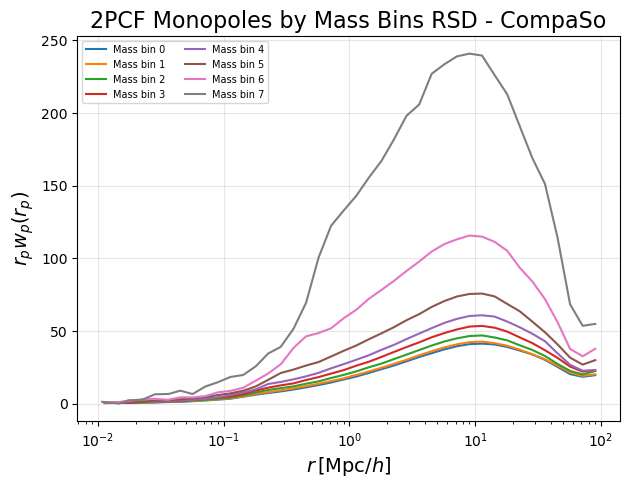

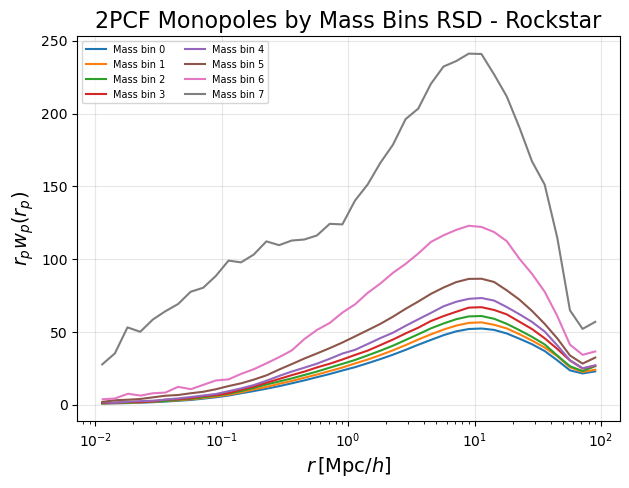

In [82]:
plot_mass_binned_quantity(
    r_hh_all=rp_all_cs_rsd, 
    quantity_all=wp_all_cs_rsd,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins RSD - CompaSo',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

plot_mass_binned_quantity(
    r_hh_all=rp_all_rs_rsd, 
    quantity_all=wp_all_rs_rsd,  
    mass_bins=mass_bins,
    scaley=None,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title='2PCF Monopoles by Mass Bins RSD - Rockstar',
    apply_transformation=lambda r, q: r * q.squeeze()  # Transformation spécifique pour la 2PCF
)

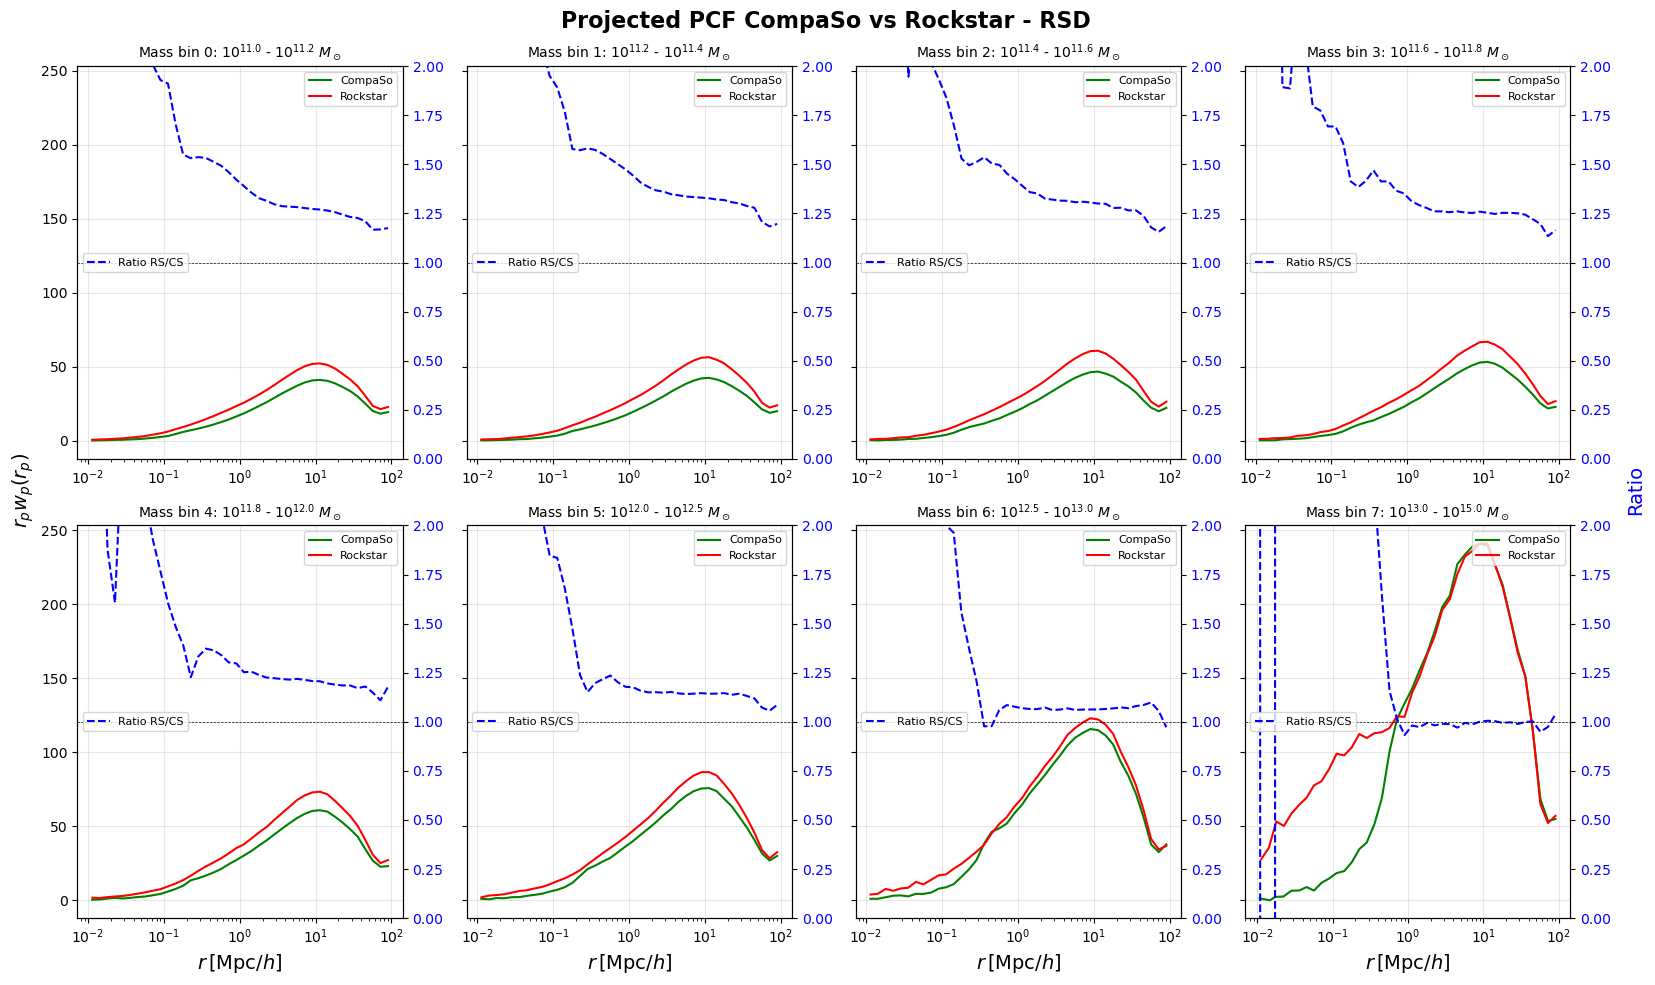

In [100]:
plot_mass_ratio_comparison(
    r_hh_all_cs=rp_all_cs_rsd, quantity_all_cs=wp_all_cs_rsd, errors_cs = False,
    r_hh_all_rs=rp_all_rs_rsd, quantity_all_rs=wp_all_rs_rsd, errors_rs = False,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$r_{p} w_{p}(r_{p})$',
    title="Projected PCF CompaSo vs Rockstar - RSD",
    rows=2, ratio_leg='center left', leg_pos='upper right',
    apply_transformation=lambda r, q: r * q.squeeze(),
    scalex='log',
    scaley=None, ratio_yrange=(0,2)
)

### Bootstrap

In [84]:
# print('CompaSo')
# bias_mono_cs_bs, bias_quad_cs_bs = bootstrap_bias_wrt_mass(mass_bins, sampled_masses_cs, positions_cs, bins_s, bins_mu, boxsize_cs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs.npz")
# print('\n', 'Rockstar')
# bias_mono_rs_bs, bias_quad_rs_bs = bootstrap_bias_wrt_mass(mass_bins, sampled_masses_rs, sampled_positions_rs, bins_s, bins_mu, boxsize_rs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs.npz")

In [85]:
# Charger le fichier .npz
data_cs_bs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs.npz")
data_rs_bs = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_bs.files)
print(data_rs_bs.files)

## CompaSo
mass_bins_cs_bs = data_cs_bs["mass_bins"]  # Bins de masse
r_hh_all_cs_bs = data_cs_bs["r_hh_all"]  # Valeurs de r pour chaque bin

xi_hh_mono_all_cs_bs = data_cs_bs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
xi_hh_quad_all_cs_bs = data_cs_bs["xi_hh_quad_all"]

bias_by_r_mono_all_cs_bs = data_cs_bs["bias_by_r_mono_all"]
bias_by_r_quad_all_cs_bs = data_cs_bs["bias_by_r_quad_all"]

mean_bias_mono_all_cs_bs =  data_cs_bs["mean_bias_mono_all"]
mean_bias_quad_all_cs_bs =  data_cs_bs["mean_bias_mono_all"]

## Rockstar

mass_bins_rs_bs = data_rs_bs["mass_bins"]  # Bins de masse
r_hh_all_rs_bs = data_rs_bs["r_hh_all"]  # Valeurs de r pour chaque bin

xi_hh_mono_all_rs_bs = data_rs_bs["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
xi_hh_quad_all_rs_bs = data_rs_bs["xi_hh_quad_all"]

bias_by_r_mono_all_rs_bs = data_rs_bs["bias_by_r_mono_all"]
bias_by_r_quad_all_rs_bs = data_rs_bs["bias_by_r_quad_all"]

mean_bias_mono_all_rs_bs =  data_rs_bs["mean_bias_mono_all"]
mean_bias_quad_all_rs_bs =  data_rs_bs["mean_bias_mono_all"]

['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_r_mono_all', 'bias_by_r_quad_all', 'mean_bias_mono_all', 'mean_bias_quad_all']
['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_r_mono_all', 'bias_by_r_quad_all', 'mean_bias_mono_all', 'mean_bias_quad_all']


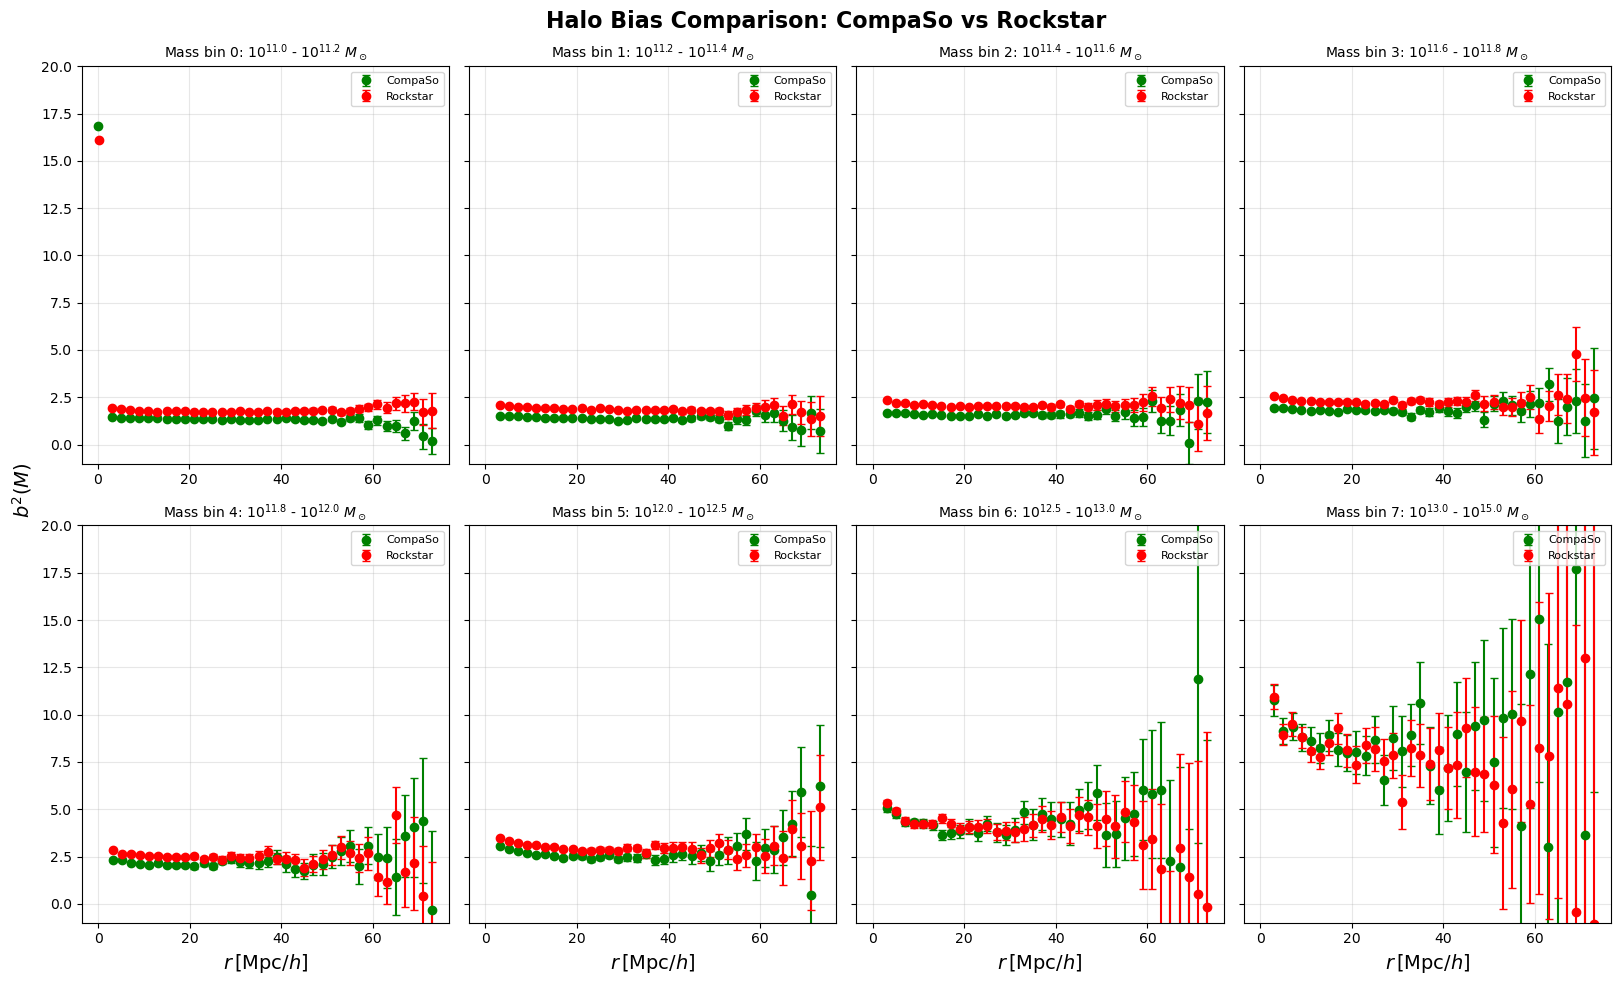

In [86]:
plot_mass_comparison(
    r_hh_all_cs=r_hh_all_cs_bs, quantity_all_cs=mean_bias_mono_all_cs_bs, errors_cs = True,
    r_hh_all_rs=r_hh_all_rs_bs, quantity_all_rs=mean_bias_mono_all_rs_bs, errors_rs = True,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2(M)$',
    title="Halo Bias Comparison: CompaSo vs Rockstar",
    rows=2,
    yrange = (-1, 20),
    mask_range=(0,75),
    scalex=None,
    scaley=None
)

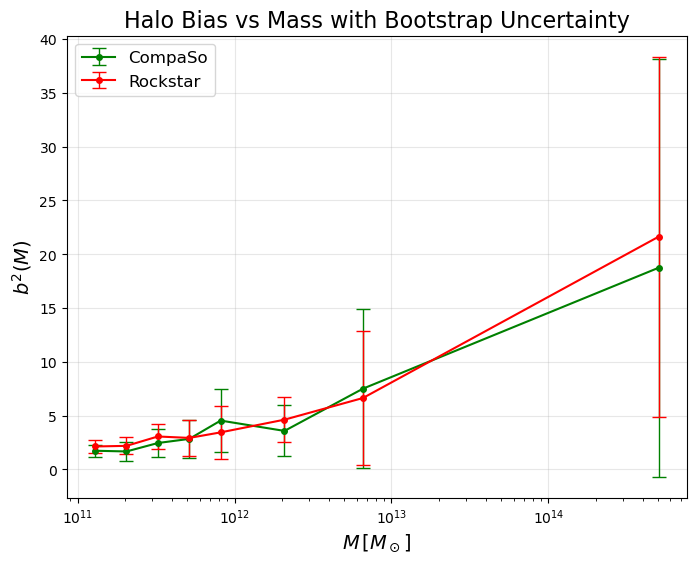

In [87]:
n_bins = len(mass_bins) - 1

bias_values_cs = np.array([np.mean(mean_bias_mono_all_cs_bs[i][0]) for i in range(n_bins)])
bias_errors_cs = np.array([np.mean(mean_bias_mono_all_cs_bs[i][1]) for i in range(n_bins)])

bias_values_rs = np.array([np.mean(mean_bias_mono_all_rs_bs[i][0]) for i in range(n_bins)])
bias_errors_rs = np.array([np.mean(mean_bias_mono_all_rs_bs[i][1]) for i in range(n_bins)])

# Milieu des bins de masse
bias_masses_cs = 0.5 * (mass_bins[:-1] + mass_bins[1:])
bias_masses_rs = 0.5 * (mass_bins[:-1] + mass_bins[1:])

plt.figure(figsize=(8, 6))
plt.errorbar(bias_masses_cs, bias_values_cs, yerr=bias_errors_cs, fmt='o-', label='CompaSo', color='green', capsize=5, markersize=4, elinewidth=1)
plt.errorbar(bias_masses_rs, bias_values_rs, yerr=bias_errors_rs, fmt='o-', label='Rockstar', 
             color='red', capsize=5, markersize=4, elinewidth=1)

plt.xscale('log')
plt.xlabel(r'$M \, [M_\odot]$', fontsize=14)
plt.ylabel(r'$b^2(M)$', fontsize=14)
plt.title("Halo Bias vs Mass with Bootstrap Uncertainty", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

In [88]:
print(mass_centers_cs)
print(bias_masses_cs)

[129244659623.05554, 204838981198.53467, 324647906852.2276, 514532257516.84564, 815478672240.0972, 2081138830084.1897, 6581138830084.189, 505000000000000.0]
[1.29244660e+11 2.04838981e+11 3.24647907e+11 5.14532258e+11
 8.15478672e+11 2.08113883e+12 6.58113883e+12 5.05000000e+14]


/global/u2/g/guittonm/functions.py:552: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(bins, data, yerr=errors, fmt='o-', label=label,


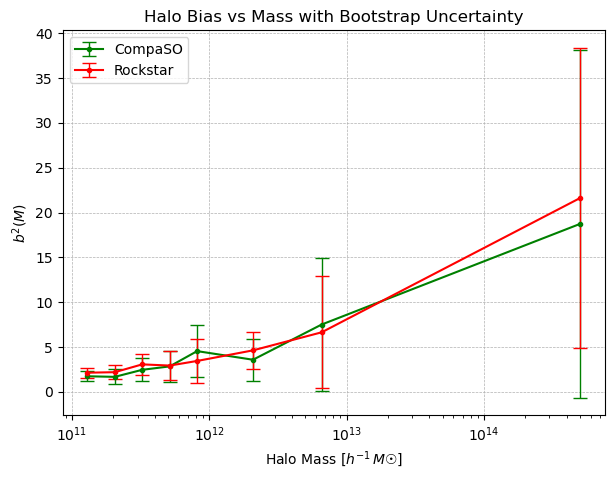

In [89]:
plot_masses_fct(data_list = [bias_values_cs, bias_values_rs],
                bins_list = [mass_centers_cs, mass_centers_rs],
                colors_list = colors_list,
                labels_list = labels_name,
                linestyles_list=['-', '-'],
                ylabel = r'$b^2(M)$', 
                title = "Halo Bias vs Mass with Bootstrap Uncertainty",
                scale = 'semilogx',
                errors_list = [bias_errors_cs, bias_errors_rs])

### Bootstrap removing

In [90]:
# print('CompaSo')
# bias_mono_cs_bs_rm, bias_quad_cs_bs_rm = removing_bias_wrt_mass(mass_bins, sampled_masses_cs, positions_cs, bins_s, bins_mu, boxsize_cs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs_rm.npz")
# print('\n', 'Rockstar')
# bias_mono_rs_bs_rm, bias_quad_rs_bs_rm = removing_bias_wrt_mass(mass_bins, sampled_masses_rs, sampled_positions_rs, bins_s, bins_mu, boxsize_rs, xi_mm_mono, xi_mm_quad, mask_range=(None,None), save_path="/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs_rm.npz")

In [91]:
# Charger le fichier .npz 
data_cs_bs_rm = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_cs_bs_rm.npz")
data_rs_bs_rm = np.load("/pscratch/sd/g/guittonm/xi_hh_mass_bins_rs_bs_rm.npz")
 
# Afficher les clés du fichier pour voir ce qu'il contient 
print(data_cs_bs_rm.files) 
print(data_rs_bs_rm.files)

## CompaSo
mass_bins_cs_bs_rm = data_cs_bs_rm["mass_bins"]  # Bins de masse
r_hh_all_cs_bs_rm = data_cs_bs_rm["r_hh_all"]  # Valeurs de r pour chaque bin

xi_hh_mono_all_cs_bs_rm = data_cs_bs_rm["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
xi_hh_quad_all_cs_bs_rm = data_cs_bs_rm["xi_hh_quad_all"]

bias_by_r_mono_all_cs_bs_rm = data_cs_bs_rm["bias_by_r_mono_all"]
bias_by_r_quad_all_cs_bs_rm = data_cs_bs_rm["bias_by_r_quad_all"]

mean_bias_mono_all_cs_bs_rm =  data_cs_bs_rm["mean_bias_mono_all"]
mean_bias_quad_all_cs_bs_rm =  data_cs_bs_rm["mean_bias_mono_all"]

## Rockstar

mass_bins_rs_bs_rm = data_rs_bs_rm["mass_bins"]  # Bins de masse
r_hh_all_rs_bs_rm = data_rs_bs_rm["r_hh_all"]  # Valeurs de r pour chaque bin

xi_hh_mono_all_rs_bs_rm = data_rs_bs_rm["xi_hh_mono_all"]  # 2PCF monopole pour chaque bin
xi_hh_quad_all_rs_bs_rm = data_rs_bs_rm["xi_hh_quad_all"]

bias_by_r_mono_all_rs_bs_rm = data_rs_bs_rm["bias_by_r_mono_all"]
bias_by_r_quad_all_rs_bs_rm = data_rs_bs_rm["bias_by_r_quad_all"]

mean_bias_mono_all_rs_bs_rm =  data_rs_bs_rm["mean_bias_mono_all"]
mean_bias_quad_all_rs_bs_rm =  data_rs_bs_rm["mean_bias_mono_all"]

['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_r_mono_all', 'bias_by_r_quad_all', 'mean_bias_mono_all', 'mean_bias_quad_all']
['mass_bins', 'r_hh_all', 'xi_hh_mono_all', 'xi_hh_quad_all', 'bias_by_r_mono_all', 'bias_by_r_quad_all', 'mean_bias_mono_all', 'mean_bias_quad_all']


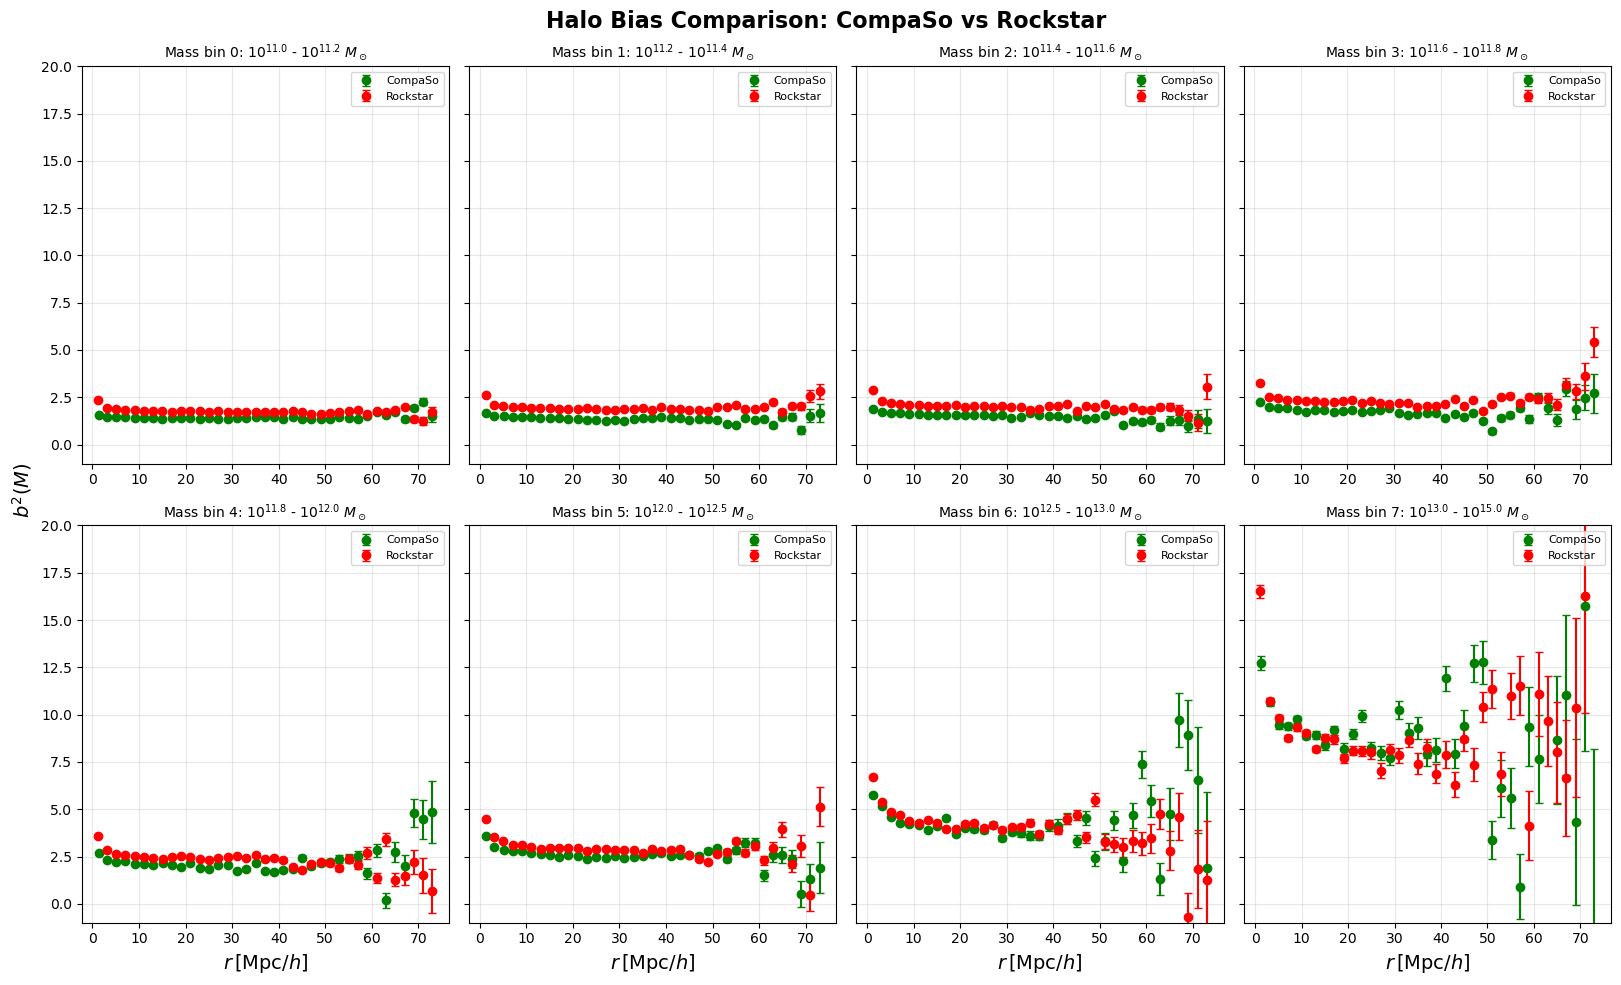

In [92]:
plot_mass_comparison(
    r_hh_all_cs=r_hh_all_cs_bs_rm, quantity_all_cs=mean_bias_mono_all_cs_bs_rm, errors_cs = True,
    r_hh_all_rs=r_hh_all_rs_bs_rm, quantity_all_rs=mean_bias_mono_all_rs_bs_rm, errors_rs = True,
    mass_bins=mass_bins, bin_edges_exp=bin_edges_exp,
    ylabel=r'$b^2(M)$',
    title="Halo Bias Comparison: CompaSo vs Rockstar",
    rows=2,
    yrange = (-1, 20),
    mask_range=(0,75),
    scalex=None,
    scaley=None
)

In [93]:
n_bins = len(mass_bins) - 1

bias_values_cs_rm = np.array([np.mean(mean_bias_mono_all_cs_bs_rm[i][0]) for i in range(n_bins)])
bias_errors_cs_rm = np.array([np.mean(mean_bias_mono_all_cs_bs_rm[i][1]) for i in range(n_bins)])

bias_values_rs_rm = np.array([np.mean(mean_bias_mono_all_rs_bs_rm[i][0]) for i in range(n_bins)])
bias_errors_rs_rm = np.array([np.mean(mean_bias_mono_all_rs_bs_rm[i][1]) for i in range(n_bins)])

# Milieu des bins de masse
bias_masses_cs_rm = 0.5 * (mass_bins[:-1] + mass_bins[1:])
bias_masses_rs_rm = 0.5 * (mass_bins[:-1] + mass_bins[1:])

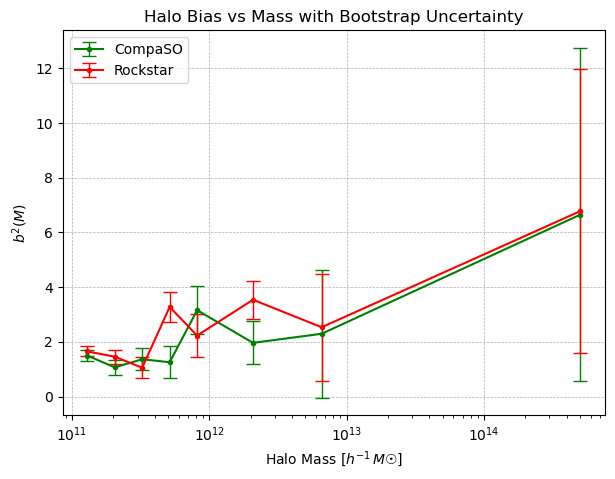

In [94]:
plot_masses_fct(data_list = [bias_values_cs_rm, bias_values_rs_rm],
                bins_list = [mass_centers_cs, mass_centers_rs],
                colors_list = colors_list,
                labels_list = labels_name,
                linestyles_list=['-', '-'],
                ylabel = r'$b^2(M)$', 
                title = "Halo Bias vs Mass with Bootstrap Uncertainty",
                scale = 'semilogx',
                errors_list = [bias_errors_cs_rm, bias_errors_rs_rm])

# Trash

### Monopole

In [96]:
# # Bias calculation
# bias_mono_cs = (xi_cs_mono / xi_mm_mono).squeeze()
# bias_mono_rs = (xi_rs_mono / xi_mm_mono).squeeze()

# plt.figure(figsize=(7, 5))
# plt.semilogx(r_cs_mono, bias_mono_cs,  marker='o', color='green', label='CompaSo - 10% halos', markersize=4)
# plt.semilogx(r_rs_mono, bias_mono_rs,  marker='o', color='red', label ='Rockstar - 10% halos', markersize=4)
# plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
# plt.ylabel(r'$b^2(M)$', fontsize=14)
# plt.title('Halos bias, monopole', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend(loc='lower left')
# plt.show()

# plt.figure(figsize=(7, 5))
# plt.semilogx(r_cs_mono, bias_mono_rs / bias_mono_cs,  marker='o', color='blue', label='Rockstar - CompaSo', markersize=4)
# plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
# plt.ylabel(r'$b^2_{\mathrm{RS}} \,/\, b^2_{\mathrm{CS}}$', fontsize=14)
# plt.title('Halos bias ratio, monopole', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend(loc='lower left')
# plt.show()

In [97]:
# def plot_bias_filtered(r_cs, bias_cs, r_rs, bias_rs, title, r_min=40, r_max=80):

#     mask_cs = (r_cs >= r_min) & (r_cs <= r_max)
#     mask_rs = (r_rs >= r_min) & (r_rs <= r_max)

#     r_cs_filtered, bias_cs_filtered = r_cs[mask_cs], bias_cs[mask_cs]
#     r_rs_filtered, bias_rs_filtered = r_rs[mask_rs], bias_rs[mask_rs]

#     # Calcul de la différence Rockstar - CompaSO
#     bias_ratio = bias_rs_filtered / bias_cs_filtered

#     # Tracé du biais des halos
#     plt.figure(figsize=(7, 5))
#     plt.semilogx(r_cs_filtered, bias_cs_filtered, marker='o', color='green', label='CompaSO', markersize=4)
#     plt.semilogx(r_rs_filtered, bias_rs_filtered, marker='o', color='red', label='Rockstar', markersize=4)
#     plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
#     plt.ylabel(r'$b^2(M)$', fontsize=14)  
#     plt.title(f'Halos bias, {title}', fontsize=14)
#     plt.grid(True, alpha=0.3)
#     ax = plt.gca()  # Récupère l'axe actuel
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(10))  # Met un tick tous les 10 Mpc/h
#     ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))  # Affichage normal (40, 50...)
#     plt.legend(loc='best')
#     plt.show()

#     # Tracé de la différence Rockstar - CompaSO
#     plt.figure(figsize=(7, 5))
#     plt.semilogx(r_cs_filtered, bias_ratio, marker='o', color='blue', label='Rockstar - CompaSO', markersize=4)
#     plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
#     plt.ylabel(r'$b^2_{\mathrm{RS}} \,/\, b^2_{\mathrm{CS}}$', fontsize=14)
#     plt.title(f'Halos bias difference, {title}', fontsize=14)
#     plt.grid(True, alpha=0.3)
#     ax = plt.gca()  # Récupère l'axe actuel
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(10))  # Met un tick tous les 10 Mpc/h
#     ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))  # Affichage normal (40, 50...)
#     plt.legend(loc='best')
#     plt.show()

In [98]:
# plot_bias_filtered(r_cs_mono, bias_mono_cs, r_rs_mono, bias_mono_rs, title='monopole')

### Quadrupole

In [99]:
# # Bias calculation
# bias_quad_cs = (xi_cs_quad / xi_mm_quad).squeeze()
# bias_quad_rs = (xi_rs_quad / xi_mm_quad).squeeze()

# plt.figure(figsize=(7, 5))
# plt.semilogx(r_cs_quad, bias_quad_cs,  marker='o', color='green', label='CompaSo', markersize=4)
# plt.semilogx(r_rs_quad, bias_quad_rs,  marker='o', color='red', label ='Rockstar', markersize=4)
# plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
# plt.ylabel(r'$b(r)$', fontsize=14)
# plt.title('Halos bias, quadrupole', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend(loc='lower left')
# plt.show()

# plt.figure(figsize=(7, 5))
# plt.semilogx(r_cs_quad, bias_quad_rs - bias_quad_cs,  marker='o', color='blue', label='Rockstar - CompaSo', markersize=4)
# plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
# plt.ylabel(r'$b(r)$', fontsize=14)
# plt.title('Halos bias difference, quadrupole', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend(loc='lower left')
# plt.show()

In [100]:
# plot_bias_filtered(r_cs_quad, bias_quad_cs, r_rs_quad, bias_quad_rs, title='quadrupole')

# RSD SMU

In [101]:
# ## CompaSo

# results_smu_cs_rsd = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Bornes des distances pour les bins
#     data_positions1=(x_cs_all, y_cs_all, z_rsd_all_cs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_cs,
#     los='z'
# )

In [102]:
# ## Rockstar

# results_smu_rs_rsd = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Bornes des distances pour les bins
#     data_positions1=(x_rs_all, y_rs_all, z_rsd_all_rs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_rs, 
#     los='z'
# ) 

In [103]:
# ## CompaSo

# results_smu_cs_rsd = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Bornes des distances pour les bins
#     data_positions1=(x_cs, y_cs, z_rsd_cs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_cs,
#     los='z'
# )

# ## Rockstar

# results_smu_rs_rsd = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_s, bins_mu),  # Bornes des distances pour les bins
#     data_positions1=(x_rs, y_rs, z_rsd_rs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_rs, 
#     los='z'
# ) 

In [104]:
# ## CompaSo

# results_smu_cs_rsd_log = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_log_s, bins_mu),  # Bornes des distances pour les bins
#     data_positions1=(x_cs, y_cs, z_rsd_cs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_cs,
#     los='z'
# )

# ## Rockstar

# results_smu_rs_rsd_log = TwoPointCorrelationFunction(
#     mode='smu',  
#     edges=(bins_log_s, bins_mu),  # Bornes des distances pour les bins
#     data_positions1=(x_rs, y_rs, z_rsd_rs),  # Positions des halos
#     nthreads=32,
#     boxsize=boxsize_rs, 
#     los='z'
# )  

In [105]:
# np.savez('/pscratch/sd/g/guittonm/smu_cs_rsd_all.npz',  
#          results_smu_cs_rsd=results_smu_cs_rsd)    
   
data_smu_cs_rsd_all = np.load('/pscratch/sd/g/guittonm/smu_cs_rsd_all.npz', allow_pickle=True)
  
results_smu_cs_rsd_all = data_smu_cs_rsd_all['results_smu_cs_rsd'].item()  
 
# np.savez('/pscratch/sd/g/guittonm/smu_rs_rsd.npz', 
#          results_smu_rs_rsd=results_smu_rs_rsd)   
 
# data_smu_rs_rsd = np.load('/pscratch/sd/g/guittonm/smu_rs_rsd.npz', allow_pickle=True)
 
# results_smu_rs_rsd = data_smu_rs_rsd['results_smu_rs_rsd'].item()  

In [106]:
# np.savez('/pscratch/sd/g/guittonm/smu_cs_rsd.npz',  
#          results_smu_cs_rsd=results_smu_cs_rsd)    
   
data_smu_cs_rsd = np.load('/pscratch/sd/g/guittonm/smu_cs_rsd.npz', allow_pickle=True)
  
results_smu_cs_rsd = data_smu_cs_rsd['results_smu_cs_rsd'].item()  
 
# np.savez('/pscratch/sd/g/guittonm/smu_rs_rsd.npz', 
#          results_smu_rs_rsd=results_smu_rs_rsd)   
 
data_smu_rs_rsd = np.load('/pscratch/sd/g/guittonm/smu_rs_rsd.npz', allow_pickle=True)
 
results_smu_rs_rsd = data_smu_rs_rsd['results_smu_rs_rsd'].item()

In [107]:
# np.savez('/pscratch/sd/g/guittonm/smu_cs_rsd_log.npz',  
#          results_smu_cs_rsd_log=results_smu_cs_rsd_log)    
   
data_smu_cs_rsd_log = np.load('/pscratch/sd/g/guittonm/smu_cs_rsd_log.npz', allow_pickle=True)
  
results_smu_cs_rsd_log = data_smu_cs_rsd_log['results_smu_cs_rsd_log'].item()  
 
# np.savez('/pscratch/sd/g/guittonm/smu_rs_rsd_log.npz', 
#          results_smu_rs_rsd_log=results_smu_rs_rsd_log)   
 
data_smu_rs_rsd_log = np.load('/pscratch/sd/g/guittonm/smu_rs_rsd_log.npz', allow_pickle=True)
 
results_smu_rs_rsd_log = data_smu_rs_rsd_log['results_smu_rs_rsd_log'].item()

In [108]:
r_cs_mono, xi_cs_mono = results_smu_cs(ells=(0,), return_sep=True)
r_rs_mono, xi_rs_mono = results_smu_rs(ells=(0,), return_sep=True)
r_mm_mono, xi_mm_mono = results_smu_mm(ells=(0,), return_sep=True)

r_cs_mono_log, xi_cs_mono_log = results_smu_cs_log(ells=(0,), return_sep=True)
r_rs_mono_log, xi_rs_mono_log = results_smu_rs_log(ells=(0,), return_sep=True)

In [109]:
r_cs_mono_rsd, xi_cs_mono_rsd = results_smu_cs_rsd(ells=(0,), return_sep=True)
r_rs_mono_rsd, xi_rs_mono_rsd = results_smu_rs_rsd(ells=(0,), return_sep=True)

r_cs_mono_rsd_log, xi_cs_mono_rsd_log = results_smu_cs_rsd_log(ells=(0,), return_sep=True)
r_rs_mono_rsd_log, xi_rs_mono_rsd_log = results_smu_rs_rsd_log(ells=(0,), return_sep=True)

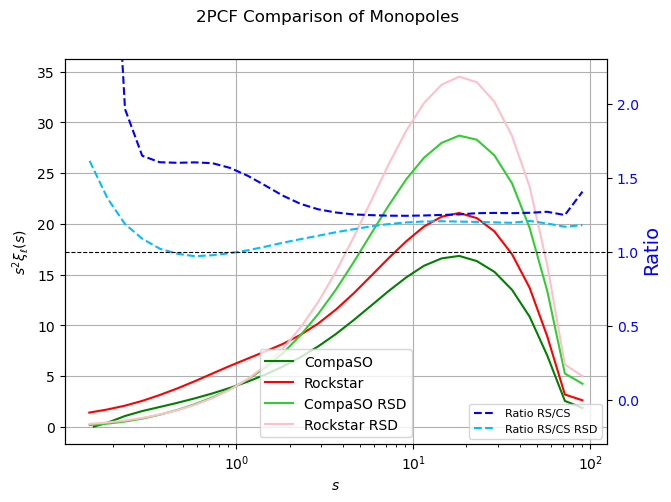

In [110]:
print_chosen_multipole_ratio(
    [r_cs_mono_log, r_rs_mono_log, r_cs_mono_rsd_log, r_rs_mono_rsd_log], 
    [xi_cs_mono_log, xi_rs_mono_log, xi_cs_mono_rsd_log, xi_rs_mono_rsd_log], [[1,0],[3,2]], 
    ["CompaSO", "Rockstar", "CompaSO RSD", "Rockstar RSD"], ratio_legends=['Ratio RS/CS', 'Ratio RS/CS RSD'],
    title="Monopoles",
    colors_list = ['green', 'red', 'limegreen', 'pink'], ratio_colors=['blue', 'deepskyblue'],
    ratio_yrange=(-0.3, 2.3), scalex='log', leg_loc='lower center', ratio_leg_loc='lower right'
)

In [111]:
r_cs_quad_log, xi_cs_quad_log = results_smu_cs_log(ells=(2,), return_sep=True)
r_rs_quad_log, xi_rs_quad_log = results_smu_rs_log(ells=(2,), return_sep=True)

r_cs_quad_rsd, xi_cs_quad_rsd = results_smu_cs_rsd(ells=(2,), return_sep=True)
r_rs_quad_rsd, xi_rs_quad_rsd = results_smu_rs_rsd(ells=(2,), return_sep=True)

r_cs_quad_rsd_log, xi_cs_quad_rsd_log = results_smu_cs_rsd_log(ells=(2,), return_sep=True)
r_rs_quad_rsd_log, xi_rs_quad_rsd_log = results_smu_rs_rsd_log(ells=(2,), return_sep=True)

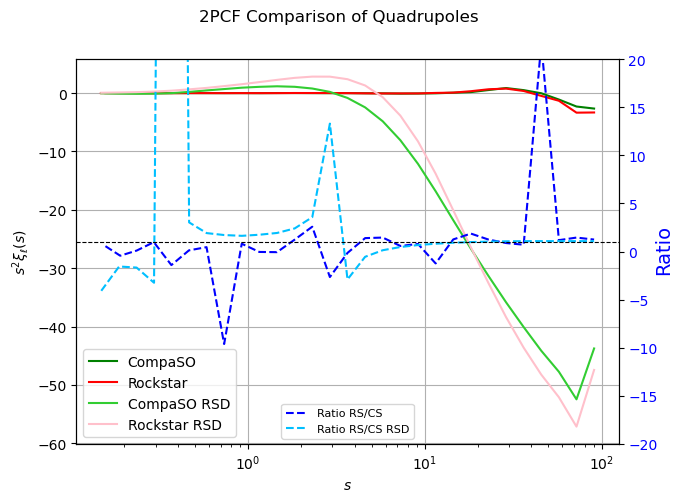

In [112]:
print_chosen_multipole_ratio(
    [r_cs_quad_log, r_rs_quad_log, r_cs_quad_rsd_log, r_rs_quad_rsd_log], 
    [xi_cs_quad_log, xi_rs_quad_log, xi_cs_quad_rsd_log, xi_rs_quad_rsd_log], [[1,0],[3,2]], 
    ["CompaSO", "Rockstar", "CompaSO RSD", "Rockstar RSD"], ratio_legends=['Ratio RS/CS', 'Ratio RS/CS RSD'],
    title="Quadrupoles",
    colors_list = ['green', 'red', 'limegreen', 'pink'], ratio_colors=['blue', 'deepskyblue'], #pink
    ratio_yrange=(-20, 20), scalex='log', ratio_leg_loc='lower center', leg_loc='lower left'
)

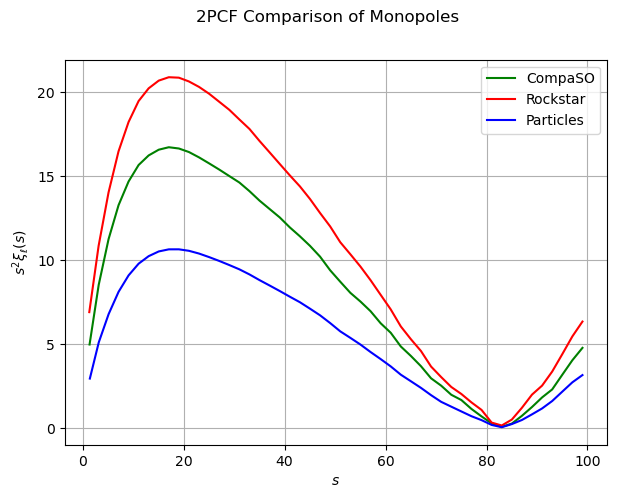

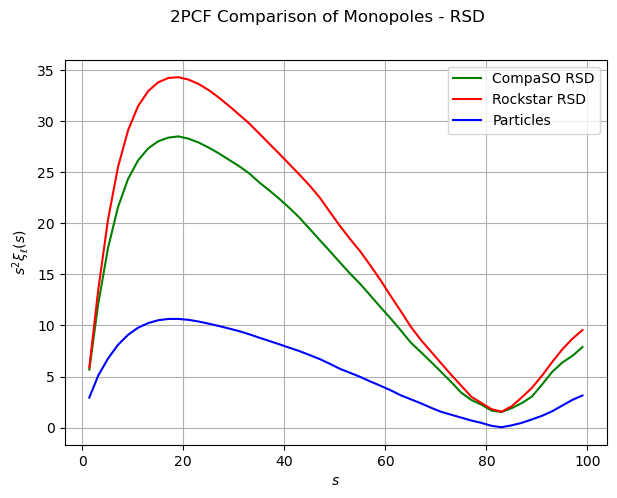

In [126]:
print_chosen_multipole(
    [r_cs_mono, r_rs_mono, r_mm_mono], 
    [xi_cs_mono, xi_rs_mono, xi_mm_mono], 
    ["CompaSO", "Rockstar", "Particles"], 
    "Monopoles",
    colors_list = ['green', 'red', 'blue']
)

print_chosen_multipole(
    [r_cs_mono_rsd, r_rs_mono_rsd, r_mm_mono, r_cs_mono, r_rs_mono,], 
    [xi_cs_mono_rsd, xi_rs_mono_rsd, xi_mm_mono], 
    ["CompaSO RSD", "Rockstar RSD", "Particles"], 
    "Monopoles - RSD",
    colors_list = ['green', 'red', 'blue']
)

# Xi_gm

In [118]:
# # Delta Sigma

# results_gm_cs = TwoPointCorrelationFunction(
#     mode='smu',
#     edges=(bins_s, bins_mu),
#     data_positions1 = positions_mm_sampled,
#     data_positions2 = (x_cs, y_cs, z_cs),
#     boxsize=boxsize_cs,
#     nthreads=32,
#     los='z'
# )

# results_gm_rs = TwoPointCorrelationFunction(
#     mode='smu',
#     edges=(bins_s, bins_mu),
#     data_positions1 = positions_mm_sampled,
#     data_positions2 = (x_rs, y_rs, z_rs),
#     boxsize=boxsize_rs,
#     nthreads=32,
#     los='z'
# )

In [119]:
# s_gm = results_gm_cs.sep  # Distances bin centrées

# r_gm_cs, xi_gm_cs = results_gm_cs(ells=(0,), return_sep=True)
# r_gm_rs, xi_gm_rs = results_gm_rs(ells=(0,), return_sep=True)

# # Enregistrement des résultats
# np.savez("/pscratch/sd/g/guittonm/results_gm.npz", 
#          results_gm_cs=results_gm_cs,
#          results_gm_rs=results_gm_rs,
#          r_gm_cs=r_gm_cs,
#          r_gm_rs=r_gm_rs,
#          xi_gm_cs=xi_gm_cs, 
#          xi_gm_rs=xi_gm_rs)

# print("Résultats enregistrés dans /pscratch/sd/g/guittonm/results_gm.npz")

In [111]:
# Charger le fichier .npz
data_gm = np.load("/pscratch/sd/g/guittonm/results_gm.npz", allow_pickle=True)

# Afficher les clés du fichier pour voir ce qu'il contient  
print(data_gm.files)

results_gm_cs = data_gm['results_gm_cs'].item()
results_gm_rs = data_gm['results_gm_rs'].item()

r_gm_cs = data_gm['r_gm_cs']
xi_gm_cs = data_gm['xi_gm_cs']

r_gm_rs = data_gm['r_gm_rs']
xi_gm_rs = data_gm['xi_gm_rs']

['results_gm_cs', 'results_gm_rs', 'r_gm_cs', 'r_gm_rs', 'xi_gm_cs', 'xi_gm_rs']


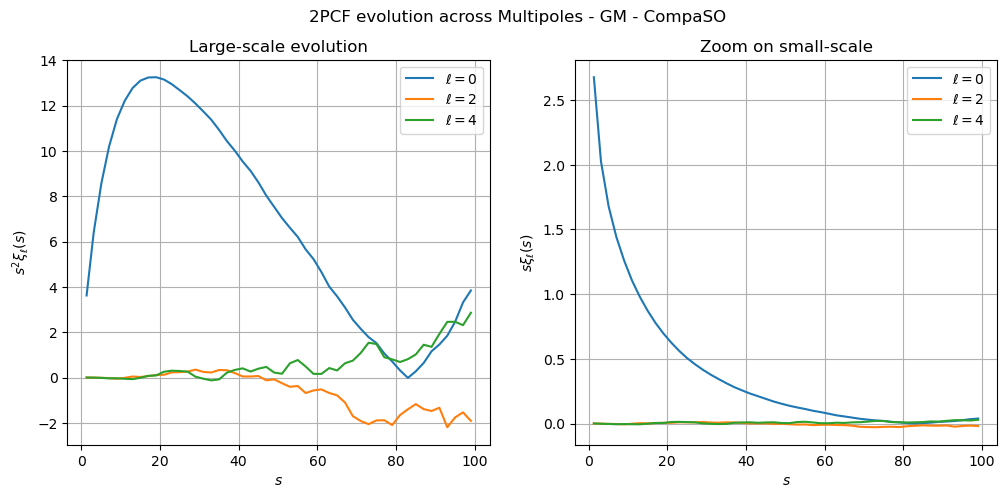

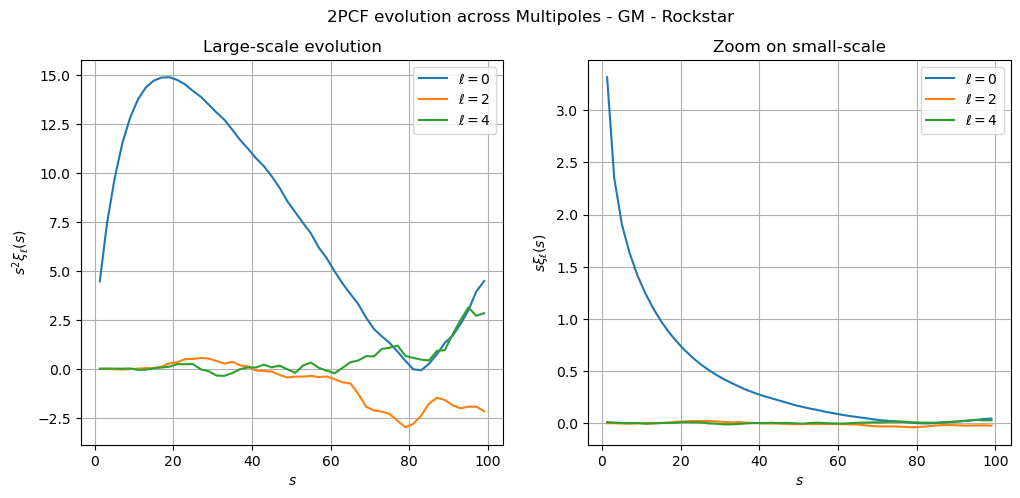

In [112]:
print_multipoles(results_gm_cs, ells, title = 'GM - CompaSO')

print_multipoles(results_gm_rs, ells, title = 'GM - Rockstar')

In [ ]:
# xi_gm_cs_per_mass_bin = []
# r_gm_cs_per_mass_bin = []

# for i, (low, high) in enumerate(zip(mass_bins[:-1], mass_bins[1:])):
#     mask = (sampled_masses_cs >= low) & (sampled_masses_cs < high)
#     halos_in_bin = np.array([x_cs[mask], y_cs[mask], z_cs[mask]])

#     if halos_in_bin.shape[1] == 0:
#         print(f"Skipping mass bin {i} because it contains no halos.")
#         continue

#     results_gm = TwoPointCorrelationFunction(
#         mode='smu',
#         edges=(bins_s, bins_mu),
#         data_positions1=positions_mm_sampled,
#         data_positions2=halos_in_bin,
#         boxsize=boxsize_cs,
#         nthreads=32,
#         los='z'
#     )

#     r_gm_cs, xi_gm = results_gm(ells=(0,), return_sep=True)  # On récupère juste le monopole
#     xi_gm_cs_per_mass_bin.append(xi_gm)
#     r_gm_cs_per_mass_bin.append(r_gm_cs)

# xi_gm_cs_per_mass_bin = np.array(xi_gm_cs_per_mass_bin)
# r_gm_cs_per_mass_bin = np.array(r_gm_cs_per_mass_bin)

# np.savez('/pscratch/sd/g/guittonm/results_gm_per_mass_bin_cs.npz', 
#             mass_bins=mass_bins, 
#             xi_gm_cs_per_mass_bin=xi_gm_cs_per_mass_bin, 
#             r_gm_cs_per_mass_bin=r_gm_cs_per_mass_bin) #             rppi_pi_all=rppi_pi_all, 

# print(f"\n Fichier enregistré")

RuntimeError: RuntimeError occurred

In [113]:
# Charger le fichier .npz
data_cs_gm = np.load("/pscratch/sd/g/guittonm/results_gm_per_mass_bin_cs.npz")

# Afficher les clés du fichier pour voir ce qu'il contient
print(data_cs_gm.files)

# Extraire les données
xi_gm_cs_per_mass_bin = data_cs_gm["xi_gm_cs_per_mass_bin"] 
r_gm_cs_per_mass_bin = data_cs_gm["r_gm_cs_per_mass_bin"] 

print(xi_gm_cs_per_mass_bin.shape)
print(r_gm_cs_per_mass_bin.shape)

['mass_bins', 'xi_gm_cs_per_mass_bin', 'r_gm_cs_per_mass_bin']
(8, 1, 50)
(8, 50)


In [114]:
mass_bin_centers = np.sqrt(mass_bins[:-1] * mass_bins[1:])

In [115]:
def plot_xigm_vs_mass(mass_bins, xi_gm_all, r_values, mass_thresholds):

    plt.figure(figsize=(8,6))

    r_values=r_values[0]
    print('shape:', r_values.shape)
    for mass_threshold in mass_thresholds:
        mask = mass_bins[:-1] > mass_threshold
        print(mask)
        if np.sum(mask) == 0:
            continue  
        
        xi_gm_all=xi_gm_all.squeeze()
        xi_gm_selected = np.mean(xi_gm_all[mask], axis=0)

        plt.loglog(r_values, xi_gm_selected, label=f"$M_{{\\rm min}} = 10^{{{np.log10(mass_threshold):.1f}}} M_\\odot$")
    
    plt.xlabel(r"$r$ [Mpc/h]")
    plt.ylabel(r"$\xi_{\rm gm}(r)$")
    plt.title(r"Galaxy-Matter Correlation $\xi_{\rm gm}(r)$ for Different Mass Thresholds")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.show()

# Exemple d'utilisation :
mass_thresholds = [10**12, 10**12.5, 10**12.8, 10**13]
plot_xigm_vs_mass(mass_bin_centers, xi_gm_cs_per_mass_bin, r_gm_cs_per_mass_bin, mass_thresholds)

shape: (50,)
[False False False False False  True  True]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 7

<Figure size 800x600 with 0 Axes>

## Mass density profile

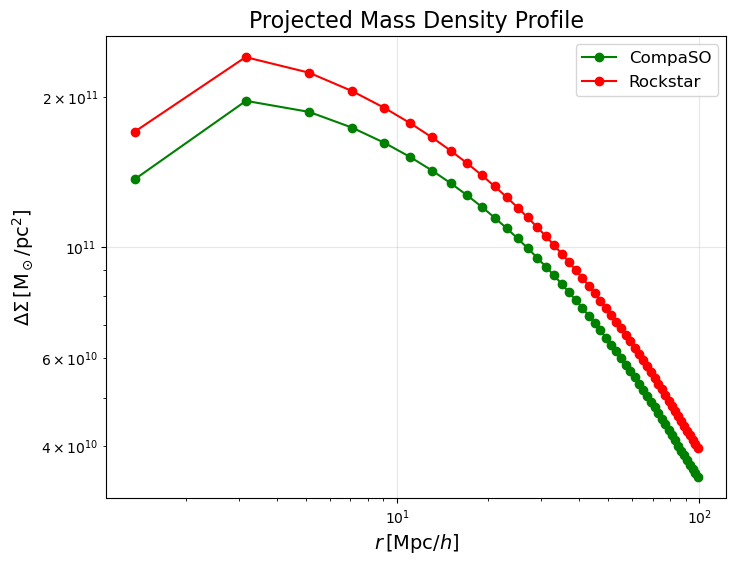

In [116]:
# Densité critique de l'univers
Omega_m = get_variable("/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_highbase_c000_ph100//halos/z0.500/header", name='Omega_M')
rho_crit = 2.775e11 * Omega_m  # Densité moyenne de la matière en M_sun/Mpc^3

# Fonction d'intégration
def delta_sigma_integrand(r_prime, r, xi_gm_interp):
    return xi_gm_interp(r_prime) * (r_prime / r)

xi_gm_interp_cs = interp1d(r_gm_cs, xi_gm_cs, kind='linear', bounds_error=False, fill_value="extrapolate")
xi_gm_interp_rs = interp1d(r_gm_rs, xi_gm_rs, kind='linear', bounds_error=False, fill_value="extrapolate")

# Calcul de Delta Sigma pour chaque r
delta_sigma_cs = []
delta_sigma_rs = []

for r in r_gm_cs:
    integral, _ = quad(delta_sigma_integrand, 1e-4, r, args=(r, xi_gm_interp_cs), limit=200, epsabs=1e-4, epsrel=1e-3)
    delta_sigma_cs.append(rho_crit * integral) 

for r in r_gm_rs:
    integral, _ = quad(delta_sigma_integrand, 1e-4, r, args=(r, xi_gm_interp_rs), limit=200, epsabs=1e-4, epsrel=1e-3)
    delta_sigma_rs.append(rho_crit * integral) 

# Convertir en tableau numpy
delta_sigma_cs= np.array(delta_sigma_cs)
delta_sigma_rs= np.array(delta_sigma_rs)

# Tracé du profil de densité de masse
plt.figure(figsize=(8, 6))
plt.loglog(r_gm_cs, delta_sigma_cs, marker='o', label=r'CompaSO', color='green')
plt.loglog(r_gm_rs, delta_sigma_rs, marker='o', label=r'Rockstar', color='red')
plt.xlabel(r"$r \, [\mathrm{Mpc}/h]$", fontsize=14)
plt.ylabel(r"$\Delta \Sigma \, [\mathrm{M_\odot / pc^2}]$", fontsize=14)
plt.title("Projected Mass Density Profile", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

In [117]:
Delta_Sigma_cs, SIGMA_MEAN_cs, SIGMA_cs = compute_HOD_lensing(r_gm_cs, xi_gm_cs, rho_crit)

Delta_Sigma_rs, SIGMA_MEAN_rs, SIGMA_rs = compute_HOD_lensing(r_gm_rs, xi_gm_rs, rho_crit)

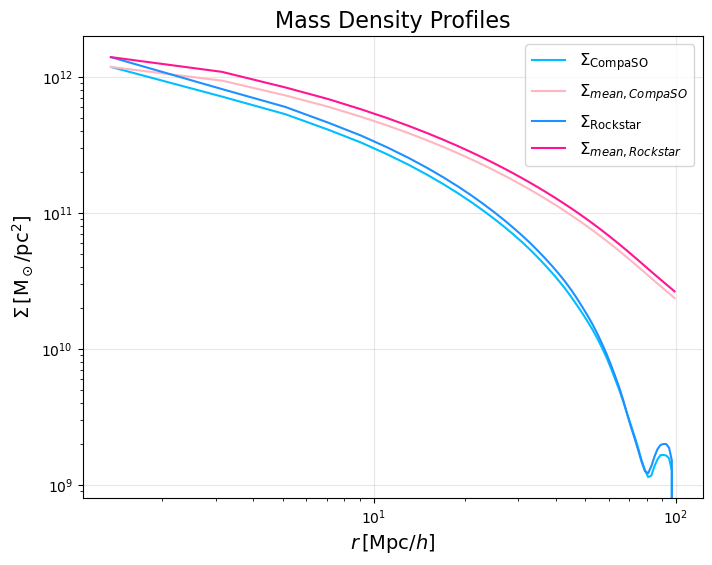

In [118]:
plt.figure(figsize=(8, 6))
plt.loglog(r_gm_cs, SIGMA_cs, label=r'$\Sigma_{\text{CompaSO}}$', color='deepskyblue')
plt.loglog(r_gm_cs, SIGMA_MEAN_cs, label=r'$\Sigma_{mean, CompaSO}$', color='lightpink')
plt.loglog(r_gm_rs, SIGMA_rs, label=r'$\Sigma_{\text{Rockstar}}$', color='dodgerblue')
plt.loglog(r_gm_rs, SIGMA_MEAN_rs, label=r'$\Sigma_{mean, Rockstar}$', color='deeppink')
plt.xlabel(r"$r \, [\mathrm{Mpc}/h]$", fontsize=14)
plt.ylabel(r"$\Sigma \, [\mathrm{M_\odot / pc^2}]$", fontsize=14)
plt.title("Mass Density Profiles", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

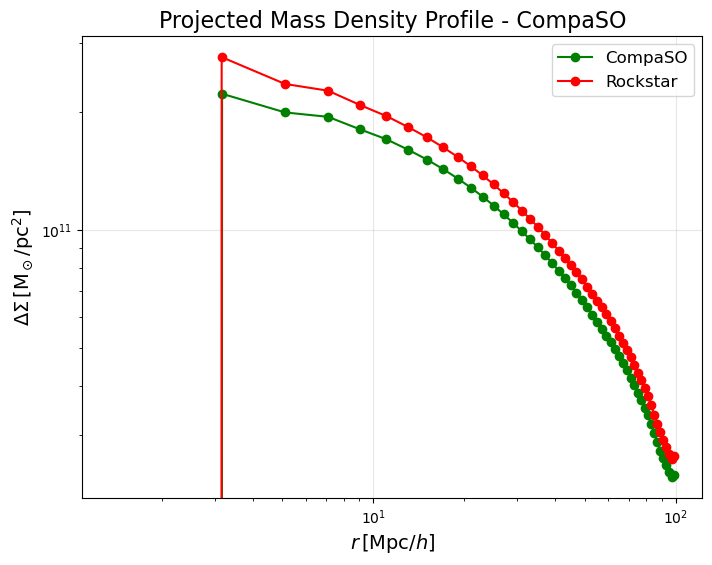

In [119]:
plt.figure(figsize=(8, 6))
plt.loglog(r_gm_cs, Delta_Sigma_cs, marker='o', label=r'CompaSO', color='green')
plt.loglog(r_gm_rs, Delta_Sigma_rs, marker='o', label=r'Rockstar', color='red')
plt.xlabel(r"$r \, [\mathrm{Mpc}/h]$", fontsize=14)
plt.ylabel(r"$\Delta \Sigma \, [\mathrm{M_\odot / pc^2}]$", fontsize=14)
plt.title("Projected Mass Density Profile - CompaSO", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

# Kd Tree

In [ ]:
def match_halos(positions_A, positions_B, max_distance=1.0):

    # Compute a KDTree on the B catalog
    tree = KDTree(positions_B)

    # Find the nearest neighbour of halos A in B  
    distances, indices_B = tree.query(positions_A)

    # Filter pairs where the distance is reasonable
    mask = distances < max_distance
    indices_A = np.arange(len(positions_A))[mask]  # Halos A with a match
    indices_B = indices_B[mask]  # corresponding halos B

    return indices_A, indices_B, distances[mask]

In [ ]:
# Associate the halos
indices_cs, indices_rs, distances = match_halos(positions_cs, sampled_positions_rs, max_distance=1.0)

# Statistical data for the differences of centers of mass 
delta_r = distances 
mean_offset = np.mean(delta_r)
std_offset = np.std(delta_r)

print(f"Moyenne du décalage des centres de masse: {mean_offset:.3f} Mpc/h")
print(f"Écart-type du décalage des centres de masse: {std_offset:.3f} Mpc/h")

In [ ]:
# Histogram of the center of mass differences
plt.figure(figsize=(8, 6))
plt.hist(delta_r, bins=100, alpha=0.7, color='blue', edgecolor='black')

plt.xlabel(r'$\Delta r$ [Mpc/h]', fontsize=14)
plt.ylabel('Nombre de halos', fontsize=14)
plt.title('Distribution des différences des centres de masse', fontsize=16)
plt.grid(True, alpha=0.3)

plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Halos positions in CompaSo (blue points)
ax.scatter(positions_cs[indices_cs, 0], positions_cs[indices_cs, 1], positions_cs[indices_cs, 2], 
           label="CompaSo", color='blue', alpha=0.5, s=5)

# Corresponding positions in Rockstar (red points)
ax.scatter(sampled_positions_rs[indices_rs, 0], sampled_positions_rs[indices_rs, 1], sampled_positions_rs[indices_rs, 2], 
           label="Rockstar", color='red', alpha=0.5, s=5)
ax.set_ylim((0,50))
ax.set_xlim((0,50))
ax.set_zlim((0,50))
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_zlabel('Z [Mpc/h]')
ax.set_title('Comparaison des positions des halos')
ax.legend()
plt.show()


In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x_min, x_max = 0, 50
y_min, y_max = 0, 50
z_min, z_max = 0, 50

# Masks
mask_cs = (
    (positions_cs[:, 0] >= x_min) & (positions_cs[:, 0] <= x_max) &
    (positions_cs[:, 1] >= y_min) & (positions_cs[:, 1] <= y_max) &
    (positions_cs[:, 2] >= z_min) & (positions_cs[:, 2] <= z_max)
)

mask_rs = (
    (sampled_positions_rs[:, 0] >= x_min) & (sampled_positions_rs[:, 0] <= x_max) &
    (sampled_positions_rs[:, 1] >= y_min) & (sampled_positions_rs[:, 1] <= y_max) &
    (sampled_positions_rs[:, 2] >= z_min) & (sampled_positions_rs[:, 2] <= z_max)
)

# Apply masks
positions_cs_filtered = positions_cs[mask_cs]
sampled_positions_rs_filtered = sampled_positions_rs[mask_rs]

# Plot
ax.scatter(positions_cs_filtered[:, 0], positions_cs_filtered[:, 1], positions_cs_filtered[:, 2], 
           label="CompaSo", color='blue', alpha=0.5, s=5)

ax.scatter(sampled_positions_rs_filtered[:, 0], sampled_positions_rs_filtered[:, 1], sampled_positions_rs_filtered[:, 2], 
           label="Rockstar", color='red', alpha=0.5, s=5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_zlim((z_min, z_max))

ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_zlabel('Z [Mpc/h]')
ax.set_title('Comparaison des positions des halos')
ax.legend()

plt.show()

In [ ]:
from scipy.spatial import cKDTree

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Define terminals
x_min, x_max = 0, 50
y_min, y_max = 0, 50
z_min, z_max = 0, 50

# Masks 
mask_cs = (
    (positions_cs[:, 0] >= x_min) & (positions_cs[:, 0] <= x_max) &
    (positions_cs[:, 1] >= y_min) & (positions_cs[:, 1] <= y_max) &
    (positions_cs[:, 2] >= z_min) & (positions_cs[:, 2] <= z_max)
)

mask_rs = (
    (sampled_positions_rs[:, 0] >= x_min) & (sampled_positions_rs[:, 0] <= x_max) &
    (sampled_positions_rs[:, 1] >= y_min) & (sampled_positions_rs[:, 1] <= y_max) &
    (sampled_positions_rs[:, 2] >= z_min) & (sampled_positions_rs[:, 2] <= z_max)
)

# Apply masks
positions_cs_filtered = positions_cs[mask_cs]
positions_rs_filtered = sampled_positions_rs[mask_rs]

# Building the KDTree for Rockstar
tree_rs = cKDTree(positions_rs_filtered)

# Find the nearest neighbour of each CompaSo halo in Rockstar
distances, indices_rs = tree_rs.query(positions_cs_filtered)

# Plot
ax.scatter(positions_cs_filtered[:, 0], positions_cs_filtered[:, 1], positions_cs_filtered[:, 2], 
           label="CompaSo", color='blue', alpha=0.5, s=5)

ax.scatter(positions_rs_filtered[:, 0], positions_rs_filtered[:, 1], positions_rs_filtered[:, 2], 
           label="Rockstar", color='red', alpha=0.5, s=5)

# Draw the lines linking the associated halos
for i, j in enumerate(indices_rs):
    x = [positions_cs_filtered[i, 0], positions_rs_filtered[j, 0]]
    y = [positions_cs_filtered[i, 1], positions_rs_filtered[j, 1]]
    z = [positions_cs_filtered[i, 2], positions_rs_filtered[j, 2]]
    ax.plot(x, y, z, color="black", alpha=0.6, linewidth=1)  # Tracer une ligne entre les deux points

# Définir les limites d'affichage
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_zlim((z_min, z_max))

# Labels et titre
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_zlabel('Z [Mpc/h]')
ax.set_title('Comparaison des positions des halos avec appariement KDTree')
ax.legend()

plt.show()

In [ ]:
plt.hist(distances, bins=100, alpha=0.7, color='blue')
plt.xlabel("Matching distance [Mpc/h]")
plt.ylabel("Number of pairs")
plt.title("Distribution of distances between associated halos")
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Compute KDTrees for both catalogues
tree_rs = cKDTree(positions_rs_filtered)
tree_cs = cKDTree(positions_cs_filtered)

# Find the nearest neighbour of each halo of CompaSo in Rockstar
distances_cs_to_rs, indices_rs = tree_rs.query(positions_cs_filtered)

# Find the nearest neighbour of each halo of Rockstar in CompaSo
distances_rs_to_cs, indices_cs = tree_cs.query(positions_rs_filtered)

# Filter the pairs that are mutually nearest neighbours
mutual_matches = []
matched_distances = []
for i, j in enumerate(indices_rs):
    if indices_cs[j] == i:  # Check the reciprocity of nearest neighbour
        mutual_matches.append((i, j))
        matched_distances.append(distances_cs_to_rs[i])

matched_distances = np.array(matched_distances)

# Filtered halos
ax.scatter(positions_cs_filtered[:, 0], positions_cs_filtered[:, 1], positions_cs_filtered[:, 2], 
           label="CompaSo", color='blue', alpha=0.5, s=5)
ax.scatter(positions_rs_filtered[:, 0], positions_rs_filtered[:, 1], positions_rs_filtered[:, 2], 
           label="Rockstar", color='red', alpha=0.5, s=5)

# Draw lines connecting only mutual pairs
for i, j in mutual_matches:
    x = [positions_cs_filtered[i, 0], positions_rs_filtered[j, 0]]
    y = [positions_cs_filtered[i, 1], positions_rs_filtered[j, 1]]
    z = [positions_cs_filtered[i, 2], positions_rs_filtered[j, 2]]
    ax.plot(x, y, z, color="black", alpha=0.6, linewidth=1)  

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_zlim((z_min, z_max))

ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_zlabel('Z [Mpc/h]')
ax.set_title('Mutual Nearest Neighbor')
ax.legend()

plt.show()

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(matched_distances, bins=100, color='blue', alpha=0.7)
plt.xlabel("Distance between paired halos [Mpc/h]", fontsize=14)
plt.ylabel("Number of pairs", fontsize=14)
plt.title("Distribution of distances between mutually paired halos", fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
matched_cs = positions_cs_filtered[indices_cs]  
matched_rs = positions_rs_filtered[indices_rs]

print(matched_cs.T.shape)

In [ ]:
results_xi_gm_matched = TwoPointCorrelationFunction(
    mode='smu',
    edges=(bins_s, bins_mu),
    data_positions1=positions_mm_sampled,  
    data_positions2=matched_cs.T, 
    boxsize=boxsize_cs,
    nthreads=32,
    los='z'
)

r_matched, xi_gm_matched = results_xi_gm_matched(ells=(0,), return_sep=True)

In [ ]:
print_multipoles(results_xi_gm_matched, ells, title = 'GM')

In [ ]:
s_gm, xiell_gm = results_gm_cs(ells=ells, return_sep=True)
s_gm_matched, xiells_gm_matched = results_xi_gm_matched(ells=ells, return_sep=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=True, sharey=True)

# Plot the difference between multipoles in each case
for i, ell in enumerate(ells):
    ax = axes[i]

    # Compute the difference
    delta_xi = (s_gm**2 * xiell_gm[i]) - (s_gm_matched**2 * xiells_gm_matched[i])

    # plot
    ax.plot(s_gm, delta_xi, label=rf'$\ell = {ell}$', color='black', linestyle='-')
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel(r'$s \, [\mathrm{Mpc}/h]$', fontsize=12)
    ax.set_title(rf'Différence $\xi_{{\ell}}$ ($\ell={ell}$)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()

axes[0].set_ylabel(r'$\Delta \xi_{\ell}(s)$', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
n_samples = 3
percent = 0.1  # 10% des halos

# tocker les résultats pour chaque échantillon
xi_gm_samples = []

for i in range(n_samples):
    print(f"🔄 Échantillon {i+1}/{n_samples}")

    ## CompaSo
    sampled_indices_cs_gm = sample_take(id=hcat_filtered['id'], mass=Mhalos_filtered_CS, percent=percent)
    sampled_halos_cs_gm = hcat_filtered[sampled_indices_cs_gm]
    sampled_positions_cs_gm = np.array(sampled_halos_cs_gm['x_L2com'])
    sampled_positions_cs_gm = sampled_positions_cs_gm.astype(np.float64)

    ## Rockstar
    sampled_indices_rs_gm = sample_take(id=ids_filtered_RS, mass=Mhalos_filtered_RS, percent=percent)
    sampled_positions_rs_gm = positions_RS[sampled_indices_rs_gm]

    # KDTree to match halos
    tree_rs = cKDTree(sampled_positions_rs_gm)
    distances, indices_rs_gm = tree_rs.query(sampled_positions_cs_gm)
 
    matched_rs = sampled_positions_rs_gm[indices_rs_gm]
    
    results_gm_cs = TwoPointCorrelationFunction(
    mode='smu',
    edges=(bins_s, bins_mu),
    data_positions1=positions_mm_sampled,  
    data_positions2=matched_rs.T, 
    boxsize=boxsize_rs,
    nthreads=32,
    los='z'
    )   

    # Compute xi_{gm} for the sample
    s_gm, xiell_gm_sample = results_gm_cs(ells=ells, return_sep=True) 

    xi_gm_samples.append(xiell_gm_sample)

# Numpy table
xi_gm_samples = np.array(xi_gm_samples)  # Shape : (n_samples, n_ells, n_r) (10, 3, 50)

xi_gm_mean = np.mean(xi_gm_samples, axis=0)
xi_gm_std = np.std(xi_gm_samples, axis=0)

# Correlation function plot with uncertainties
fig, axes = plt.subplots(nrows=1, ncols=len(ells), figsize=(15, 5), sharex=True, sharey=True)

for i, ell in enumerate(ells):
    ax = axes[i]
    ax.plot(s_gm, s_gm**2 * xi_gm_mean[i], label=rf'mean', color='blue')
    ax.plot(s_gm, s_gm**2 * xi_gm_std[i], label=rf'std', color='black')
    ax.fill_between(s_gm, s_gm**2 * (xi_gm_mean[i] - xi_gm_std[i]), s_gm**2 * (xi_gm_mean[i] + xi_gm_std[i]),
                    color='blue', alpha=0.2, label="Bootstrap error")
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel(r'$s \, [\mathrm{Mpc}/h]$', fontsize=12)
    ax.set_title(rf'$s^{2}\xi_{ell}$', fontsize=14)
    ax.grid(True, alpha=0.3)  
    ax.legend() 

axes[0].set_ylabel(r'$s^{2} \xi_{\ell}(s)$', fontsize=14)  
plt.tight_layout()
plt.show()

In [ ]:
# Correlation function plot with uncertainties
fig, axes = plt.subplots(nrows=1, ncols=len(ells), figsize=(15, 5), sharex=True, sharey=True)

for i, ell in enumerate(ells):
    ax = axes[i]
    ax.plot(s_gm, s_gm**2 * xi_gm_mean[i], label=rf'mean', color='blue')
    ax.plot(s_gm, s_gm**2 * xi_gm_std[i], label=rf'std', color='black')
    ax.fill_between(s_gm, s_gm**2 * (xi_gm_mean[i] - xi_gm_std[i]), s_gm**2 * (xi_gm_mean[i] + xi_gm_std[i]),
                    color='blue', alpha=0.2, label="Bootstrap error") 
     
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel(r'$s \, [\mathrm{Mpc}/h]$', fontsize=12) 
    ax.grid(True, alpha=0.3) 
    ax.legend()   

axes[0].set_ylabel(r'$s^{2} \xi_{\ell}(s)$', fontsize=14)  
axes[1].set_title('2PCF with uncertainties', fontsize=14)
plt.tight_layout() 
plt.show()

In [ ]:
print(xi_gm_mean) 
print(xi_gm_std) 